# Lab 2: LSTM Encoder-Decoder with Attention for Decimal-to-Roman Translation

## Neural Networks Course - MEPhI

This notebook implements and investigates sequence-to-sequence models with attention for translating decimal numbers to Roman numerals.

### Contents:
1. Setup and Data Preparation
2. Dataset Statistics and Visualization
3. Baseline Model Training
4. Experimental Studies:
   - Sequence length analysis
   - Architecture parameters (layers, hidden size, embeddings)
   - Regularization (dropout, weight decay, label smoothing)
   - Cell types (LSTM vs GRU)
   - Bidirectional vs Unidirectional encoder
   - Embedding types (learned vs one-hot)
   - Attention methods (dot, general, concat)
5. Decoding Strategies Comparison
6. Visualization and Error Analysis
7. Conclusions

In [1]:
# !git clone https://github.com/Tishran/neural-networks-labs.git
# %cd ./neural-networks-labs
# !rm ./experiments.ipynb

## 1. Setup and Imports

In [2]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.abspath('.'))

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
from pathlib import Path
from collections import defaultdict
import random

# Our modules
from src.data import (
    create_datasets, create_dataloaders, get_dataset_statistics,
    decimal_to_roman, Vocabulary
)
from src.models import create_model, Seq2Seq, Encoder, Decoder
from src.attention import LuongAttention
from src.trainer import Trainer, get_device, count_parameters
from src.metrics import (
    calculate_metrics, levenshtein_distance, position_wise_accuracy,
    confusion_matrix_for_position, analyze_errors_by_length, analyze_errors_by_range
)
from src.decoding import decode_with_strategy, greedy_decode, beam_search
from src.visualization import (plot_training_curves_comparison,
    plot_training_curves, plot_attention_matrix, plot_data_statistics,
    plot_error_matrices, plot_position_errors, plot_metrics_comparison,
    plot_error_by_length, plot_multiple_attention, plot_decoding_comparison
)
from src.config import (
    ExperimentConfig, DataConfig, ModelConfig, TrainingConfig,
    get_baseline_config, get_experiment_configs, get_decoding_configs
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Device setup
device = get_device()
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Create directories
Path('checkpoints').mkdir(exist_ok=True)
Path('results').mkdir(exist_ok=True)
Path('figures').mkdir(exist_ok=True)

Using device: cuda
GPU: NVIDIA RTX A1000 6GB Laptop GPU
Memory: 6.4 GB


## 2. Dataset Preparation and Statistics

In [3]:
# Create datasets
# Non-overlapping splits: train/val/test have DIFFERENT numbers for generalization testing
train_dataset, val_dataset, test_dataset, src_vocab, tgt_vocab = create_datasets(
    min_num=1,
    max_num=3999,  # Extended range with vinculum notation
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    seed=42,
    sample_size=3999  # Total 80K: 64K train, 8K val, 8K test
)

print(f"Source vocabulary size: {len(src_vocab)} (digits + special tokens)")
print(f"Target vocabulary size: {len(tgt_vocab)} (Roman numerals + special tokens)")
print(f"Dataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Validation: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")
print(f"Max source length: {train_dataset.max_src_len}")
print(f"Max target length: {train_dataset.max_tgt_len}")
print(f"Note: Train/Val/Test contain NON-OVERLAPPING numbers for generalization testing")

Source vocabulary size: 13 (digits + special tokens)
Target vocabulary size: 10 (Roman numerals + special tokens)
Dataset sizes:
  Train: 3199
  Validation: 399
  Test: 401
Max source length: 4
Max target length: 17
Note: Train/Val/Test contain NON-OVERLAPPING numbers for generalization testing


In [4]:
# Show some examples
print("Sample conversions:")
print("-" * 40)
for i in range(10):
    sample = train_dataset[i]
    print(f"{sample['decimal_str']:>4} -> {sample['roman_str']}")

Sample conversions:
----------------------------------------
1824 -> MDCCCXXIV
 229 -> CCXXIX
3046 -> MMMXLVI
3202 -> MMMCCII
2730 -> MMDCCXXX
2785 -> MMDCCLXXXV
2938 -> MMCMXXXVIII
3103 -> MMMCIII
3521 -> MMMDXXI
2799 -> MMDCCXCIX


In [5]:
# Dataset statistics
train_stats = get_dataset_statistics(train_dataset)
print(f"\nTraining set statistics:")
print(f"  Number range: {train_stats['number_range']}")
print(f"  Digit frequencies: {train_stats['digit_freq']}")
print(f"  Roman numeral frequencies: {train_stats['roman_freq']}")


Training set statistics:
  Number range: (1, 3999)
  Digit frequencies: {'1': 1772, '8': 955, '2': 1739, '4': 964, '9': 963, '3': 1768, '0': 864, '6': 959, '7': 945, '5': 987}
  Roman numeral frequencies: {'M': 5143, 'D': 1608, 'C': 4827, 'X': 4735, 'I': 4453, 'V': 1602, 'L': 1600}


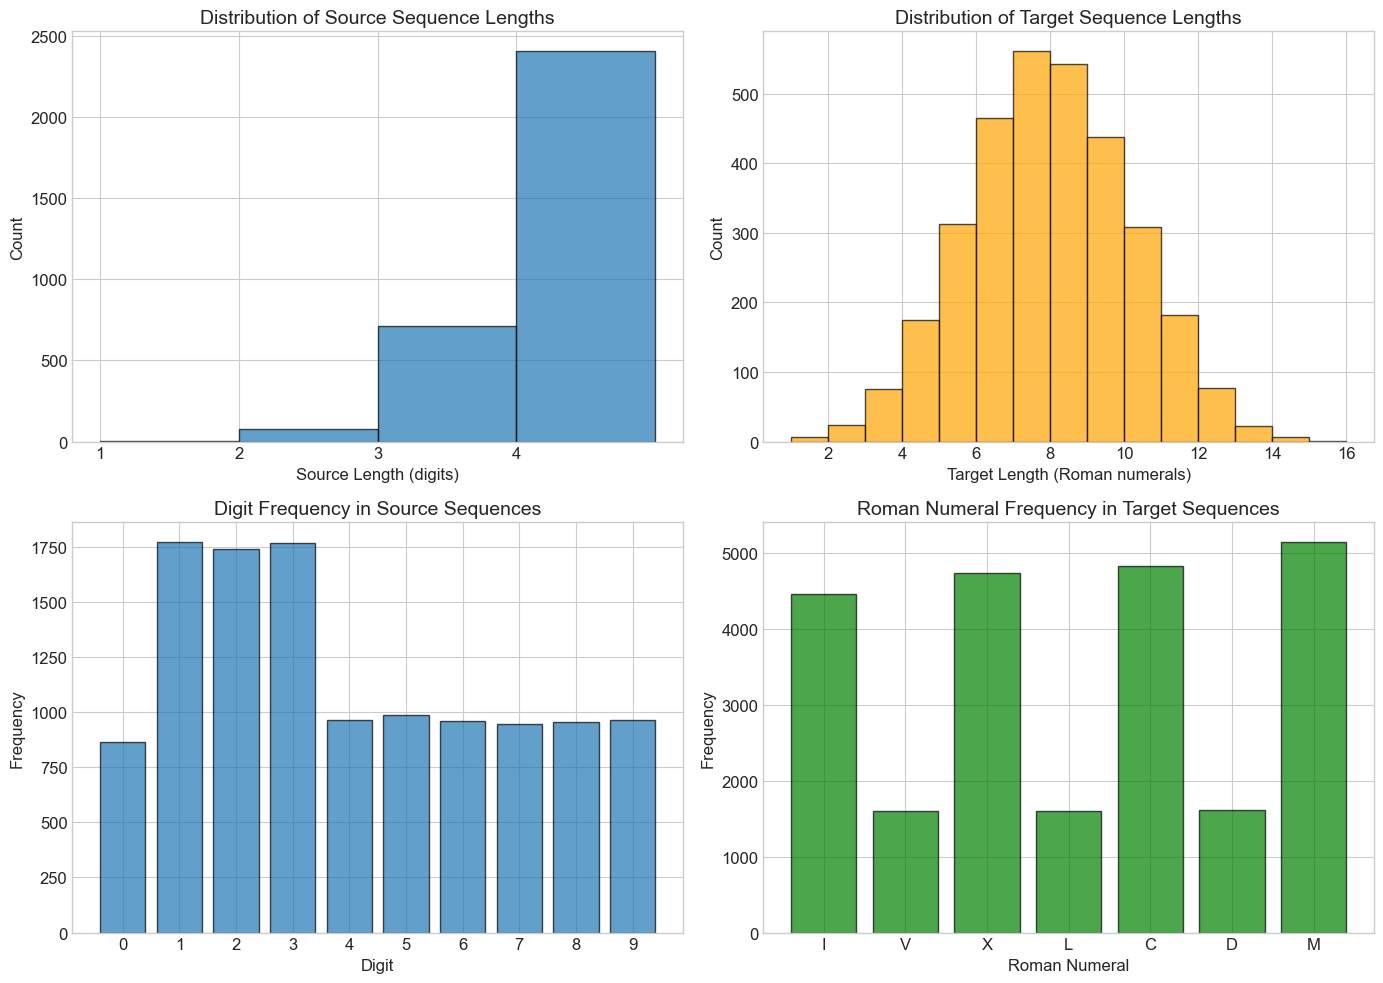

In [6]:
# Visualize dataset statistics
fig = plot_data_statistics(train_stats, save_path='figures/data_statistics.png')
plt.show()

## 3. Baseline Model Training

In [7]:
def run_experiment(config: ExperimentConfig, train_ds, val_ds, test_ds, 
                   src_vocab, tgt_vocab, device, verbose=True, show_examples=5,
                   resume_from_checkpoint=True):
    """
    Run a complete experiment with given configuration.
    
    Args:
        resume_from_checkpoint: If True, skip training if checkpoint exists and just evaluate
    
    Returns: dict with model, trainer, history, and test metrics
    """
    set_seed(config.seed)
    
    checkpoint_path = Path(f'checkpoints/{config.name}/best_model.pt')
    
    # Check if we can skip training (checkpoint exists)
    if resume_from_checkpoint and checkpoint_path.exists():
        if verbose:
            print(f"Experiment: {config.name}")
            print(f"[RESUME] Found existing checkpoint, skipping training...")
        
        # Create model and trainer just for evaluation
        model = create_model(
            src_vocab_size=len(src_vocab),
            tgt_vocab_size=len(tgt_vocab),
            embed_size=config.model.embed_size,
            hidden_size=config.model.hidden_size,
            num_layers=config.model.num_layers,
            cell_type=config.model.cell_type,
            bidirectional=config.model.bidirectional,
            attention_method=config.model.attention_method,
            dropout=config.model.dropout,
            embedding_type=config.model.embedding_type,
            pad_idx=src_vocab.pad_idx,
            sos_idx=tgt_vocab.sos_idx,
            eos_idx=tgt_vocab.eos_idx
        )
        
        trainer = Trainer(
            model=model,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            device=device,
            learning_rate=config.training.learning_rate
        )
        
        # Load checkpoint and get history
        checkpoint = trainer.load_checkpoint(checkpoint_path)
        history = checkpoint.get('history', trainer.history)
        
        if verbose:
            print(f"Model parameters: {count_parameters(model):,}")
            print(f"Loaded from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        # Full training
        # Create dataloaders
        train_loader, val_loader, test_loader = create_dataloaders(
            train_ds, val_ds, test_ds,
            batch_size=config.training.batch_size
        )
        
        # Create model
        model = create_model(
            src_vocab_size=len(src_vocab),
            tgt_vocab_size=len(tgt_vocab),
            embed_size=config.model.embed_size,
            hidden_size=config.model.hidden_size,
            num_layers=config.model.num_layers,
            cell_type=config.model.cell_type,
            bidirectional=config.model.bidirectional,
            attention_method=config.model.attention_method,
            dropout=config.model.dropout,
            embedding_type=config.model.embedding_type,
            pad_idx=src_vocab.pad_idx,
            sos_idx=tgt_vocab.sos_idx,
            eos_idx=tgt_vocab.eos_idx
        )
        
        if verbose:
            print(f"Experiment: {config.name}")
            print(f"Model parameters: {count_parameters(model):,}")
        
        # Create trainer
        trainer = Trainer(
            model=model,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            device=device,
            learning_rate=config.training.learning_rate,
            weight_decay=config.training.weight_decay,
            grad_clip=config.training.grad_clip,
            label_smoothing=config.training.label_smoothing,
            optimizer_type=config.training.optimizer_type,
            scheduler_type=config.training.scheduler_type,
            scheduler_params=config.training.scheduler_params
        )
        
        # Train
        history = trainer.fit(
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=config.training.epochs,
            teacher_forcing_ratio=config.training.teacher_forcing_ratio,
            teacher_forcing_decay=config.training.teacher_forcing_decay,
            early_stopping_patience=config.training.early_stopping_patience,
            checkpoint_dir=f'checkpoints/{config.name}',
            verbose=verbose,
            show_examples=show_examples
        )
        
        # Load best model for evaluation
        if checkpoint_path.exists():
            trainer.load_checkpoint(checkpoint_path)
    
    # Evaluate on test set
    _, _, test_loader = create_dataloaders(
        train_ds, val_ds, test_ds,
        batch_size=config.training.batch_size
    )
    
    test_loss, test_loss_std, test_metrics, test_acc_std, predictions, targets = trainer.evaluate(test_loader)
    
    if verbose:
        print(f"Test Results:")
        print(f"  Loss: {test_loss:.4f} (±{test_loss_std:.4f})")
        print(f"  Sequence Accuracy: {test_metrics['seq_accuracy']:.2%} (±{test_acc_std:.2%})")
        print(f"  Character Accuracy: {test_metrics['char_accuracy']:.2%}")
        print(f"  Mean Levenshtein Distance: {test_metrics['mean_levenshtein']:.3f}")
        print(f"  Normalized Levenshtein: {test_metrics['mean_normalized_levenshtein']:.4f}")
        
        # Show sample predictions
        print(f"Sample Predictions:")
        n_samples = min(5, len(predictions))
        for i in range(n_samples):
            status = 'OK' if predictions[i] == targets[i] else 'X'
            print(f"    [{status}] pred: {predictions[i]} | target: {targets[i]}")
    
    return {
        'model': model,
        'trainer': trainer,
        'history': history,
        'test_loss': test_loss,
        'test_loss_std': test_loss_std,
        'test_metrics': test_metrics,
        'test_acc_std': test_acc_std,
        'predictions': predictions,
        'targets': targets,
        'config': config
    }


In [8]:
# Run baseline experiment
baseline_config = get_baseline_config()
baseline_config.training.epochs = 10

baseline_result = run_experiment(
    baseline_config, 
    train_dataset, val_dataset, test_dataset,
    src_vocab, tgt_vocab, device
)

Experiment: baseline
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


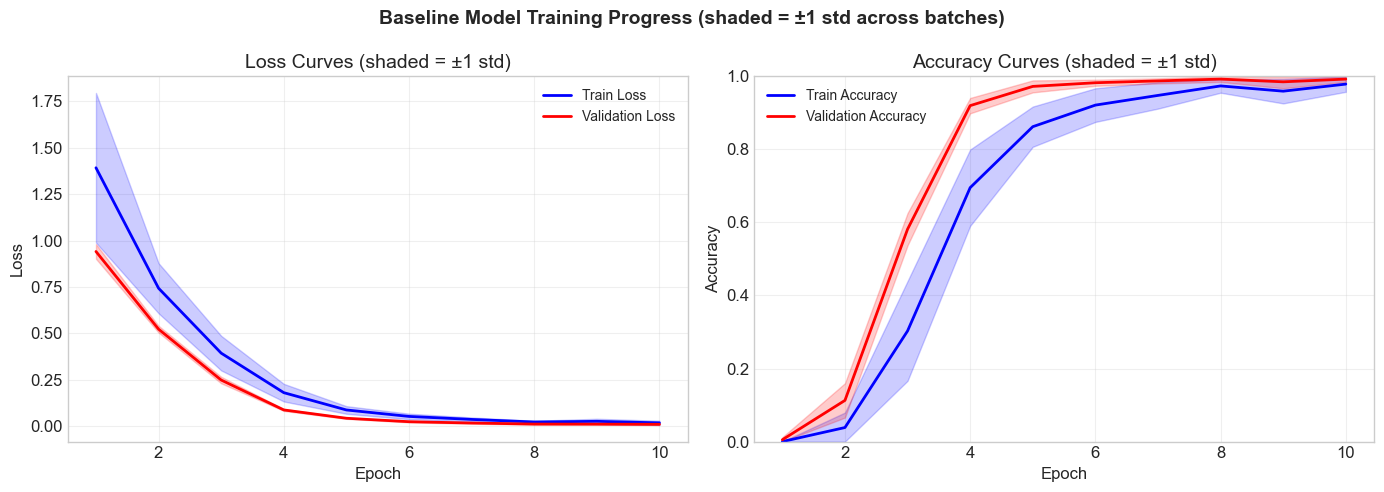

In [9]:
# Plot training curves for baseline (with std shading)
fig = plot_training_curves(
    baseline_result['history']['train_loss'],
    baseline_result['history']['val_loss'],
    baseline_result['history']['train_seq_acc'],
    baseline_result['history']['val_seq_acc'],
    train_loss_std=baseline_result['history'].get('train_loss_std'),
    val_loss_std=baseline_result['history'].get('val_loss_std'),
    train_acc_std=baseline_result['history'].get('train_seq_acc_std'),
    val_acc_std=baseline_result['history'].get('val_seq_acc_std'),
    title='Baseline Model Training Progress (shaded = ±1 std across batches)',
    save_path='figures/baseline_training.png'
)
plt.show()

## 4. Experimental Studies

### 4.1 Sequence Length Analysis

In [10]:
# Experiment with different number ranges (affects sequence length and complexity)
range_results = {}

# Test various ranges including extended vinculum notation
for max_num in [99, 999, 3999]:
    print(f"\n{'='*60}")
    print(f"Training with numbers 1-{max_num}")
    print('='*60)
    
    # Create datasets for this range
    train_ds, val_ds, test_ds, src_v, tgt_v = create_datasets(
        min_num=1, max_num=max_num, seed=42
    )
    
    config = get_baseline_config()
    config.name = f"range_{max_num}"
    config.data.max_num = max_num
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_ds, val_ds, test_ds,
        src_v, tgt_v, device, verbose=True
    )
    range_results[f"1-{max_num}"] = {'test_metrics': result['test_metrics'], 'history': result['history']}


Training with numbers 1-99
Experiment: range_99
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 1.1708 (±0.0000)
  Sequence Accuracy: 0.00% (±0.00%)
  Character Accuracy: 37.50%
  Mean Levenshtein Distance: 2.364
  Normalized Levenshtein: 0.4775
Sample Predictions:
    [X] pred: XXXII | target: LXX
    [X] pred: XXXII | target: LXXXVII
    [X] pred: XXXII | target: XIV
    [X] pred: XXXII | target: XVIII
    [X] pred: XXII | target: XXIX

Training with numbers 1-999
Experiment: range_999
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.1443 (±0.0008)
  Sequence Accuracy: 84.16% (±0.30%)
  Character Accuracy: 90.02%
  Mean Levenshtein Distance: 0.376
  Normalized Levenshtein: 0.0688
Sample Predictions:
    [OK] pred: CCLXXIV | target: CCLXXIV
    [OK] pred: DCLXXXVII | target: DCLXXXVII
    [OK] pred: CCXV | target: CCXV
    [X] pred: CCCLXVI | target: CCCLXIV
    [OK] pred: CCCLXXX | target: CCCLXXX

Training with numbers 1-3999
Experiment: range_3999
[RESUME] Found existing checkpoint, skipping training...


Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


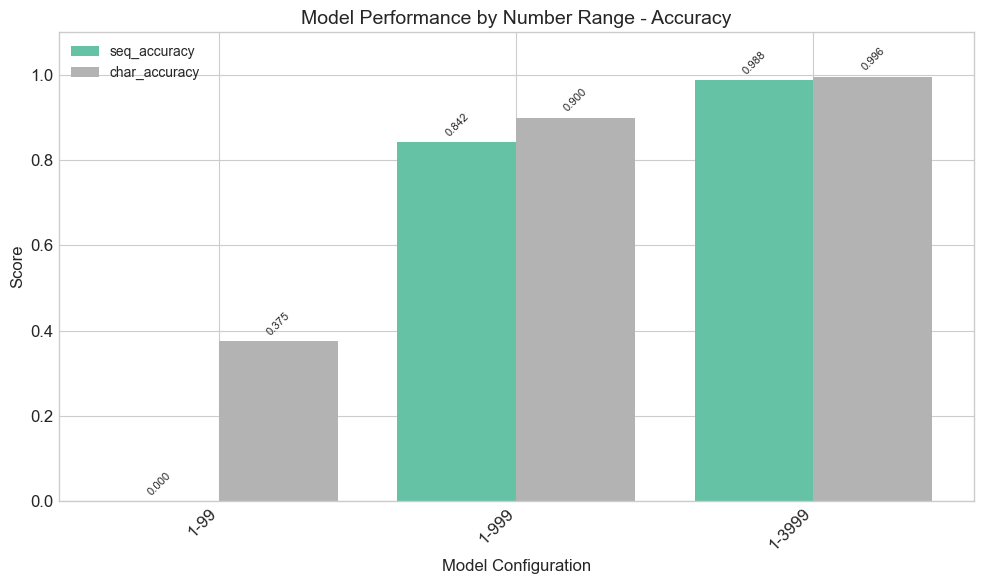

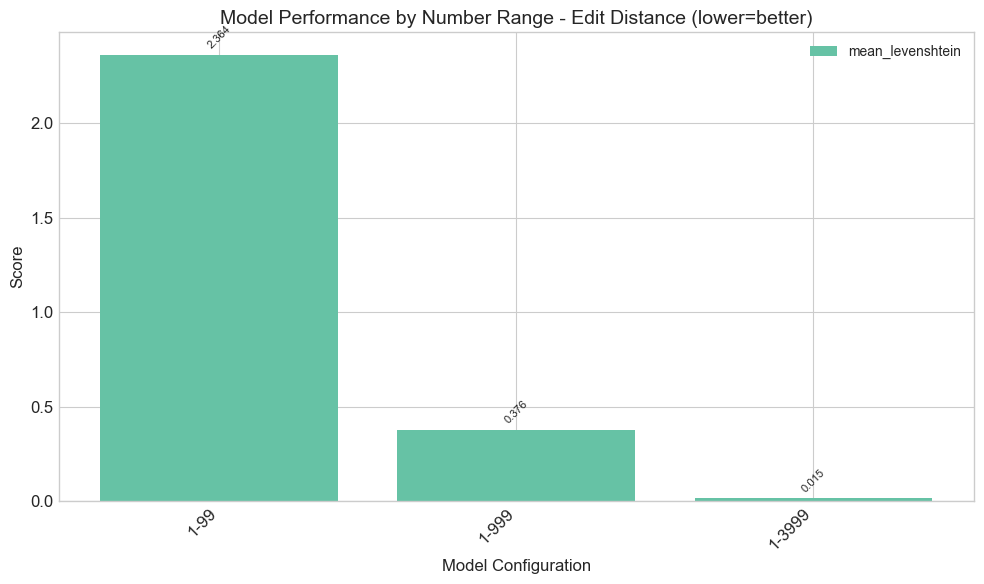

In [11]:
# Visualize range comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    range_results,
    ['seq_accuracy', 'char_accuracy'],
    title='Model Performance by Number Range - Accuracy',
    save_path='figures/range_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    range_results,
    ['mean_levenshtein'],
    title='Model Performance by Number Range - Edit Distance (lower=better)',
    save_path='figures/range_comparison_levenshtein.png'
)
plt.show()
plt.show()

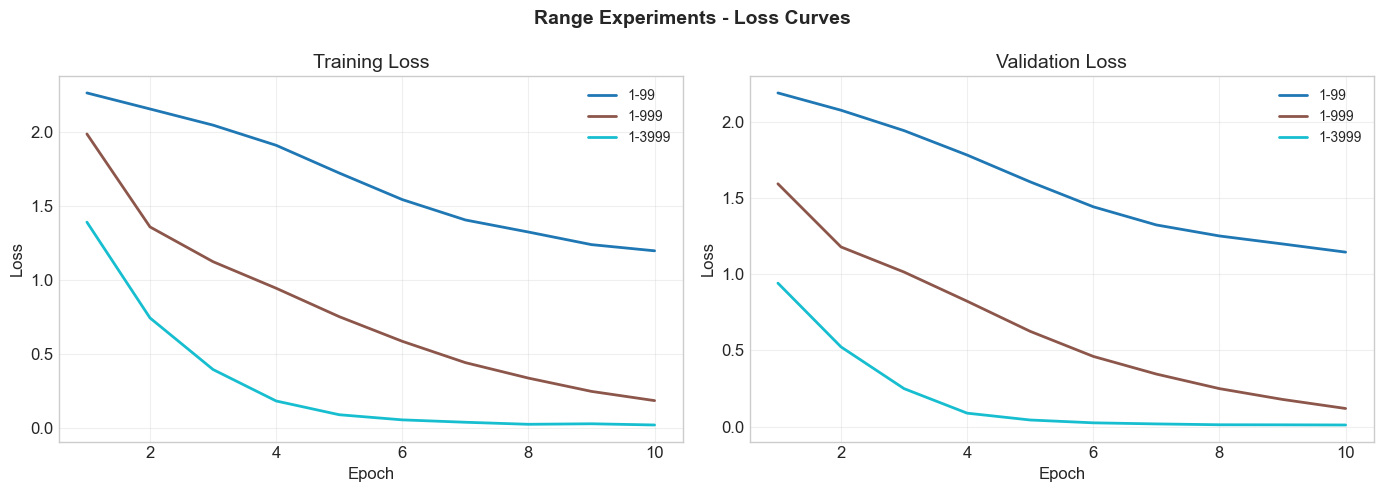

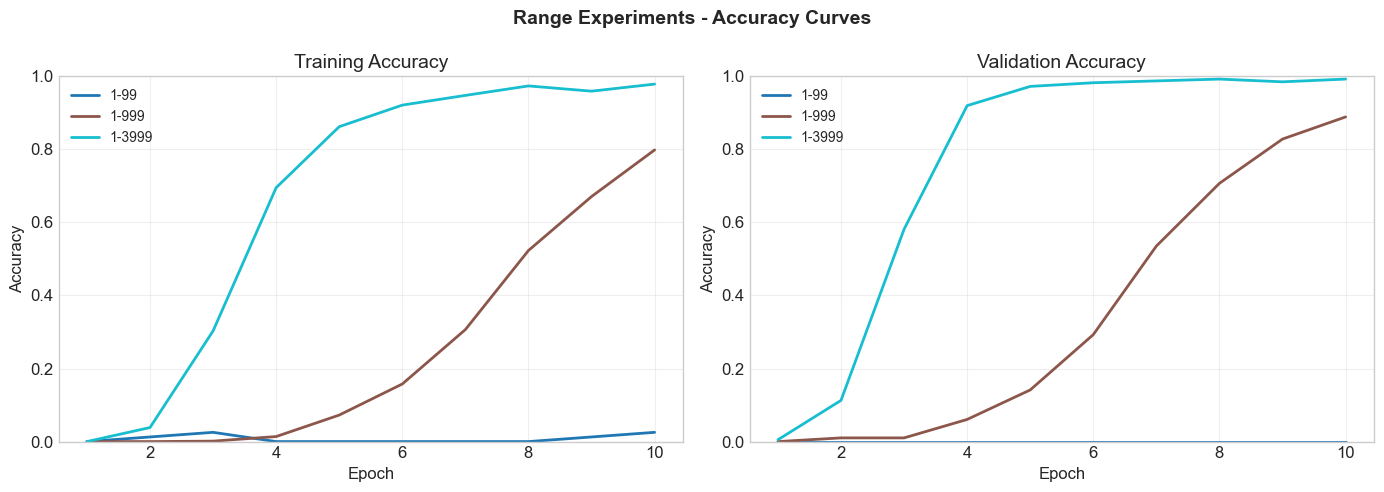

In [12]:
# Training curves for range experiments
fig = plot_training_curves_comparison(
    range_results,
    metric='loss',
    title='Range Experiments - Loss Curves',
    save_path='figures/range_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    range_results,
    metric='accuracy',
    title='Range Experiments - Accuracy Curves',
    save_path='figures/range_acc_curves.png'
)
plt.show()

### 4.2 Architecture Parameters - Hidden Size

In [13]:
# Experiment with different hidden sizes
hidden_results = {}

for hidden_size in [64, 128, 256, 512]:
    print(f"\n{'='*60}")
    print(f"Hidden size: {hidden_size}")
    print('='*60)
    
    config = get_baseline_config()
    config.name = f"hidden_{hidden_size}"
    config.model.hidden_size = hidden_size
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_dataset, val_dataset, test_dataset,
        src_vocab, tgt_vocab, device, verbose=True
    )
    hidden_results[f"H={hidden_size}"] = {'test_metrics': result['test_metrics'], 'history': result['history']}
    hidden_results[f"H={hidden_size}"]['test_metrics']['params'] = count_parameters(result['model'])


Hidden size: 64
Experiment: hidden_64
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 81,034
Loaded from epoch 10


Test Results:
  Loss: 0.0260 (±0.0043)
  Sequence Accuracy: 98.00% (±1.00%)
  Character Accuracy: 99.40%
  Mean Levenshtein Distance: 0.032
  Normalized Levenshtein: 0.0072
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Hidden size: 128
Experiment: hidden_128
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Hidden size: 256
Experiment: hidden_256
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 860,362
Loaded from epoch 10


Test Results:
  Loss: 0.0065 (±0.0046)
  Sequence Accuracy: 99.00% (±1.14%)
  Character Accuracy: 99.73%
  Mean Levenshtein Distance: 0.010
  Normalized Levenshtein: 0.0026
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Hidden size: 512
Experiment: hidden_512
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 3,161,034
Loaded from epoch 10


Test Results:
  Loss: 0.0014 (±0.0016)
  Sequence Accuracy: 99.75% (±0.55%)
  Character Accuracy: 99.90%
  Mean Levenshtein Distance: 0.002
  Normalized Levenshtein: 0.0008
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


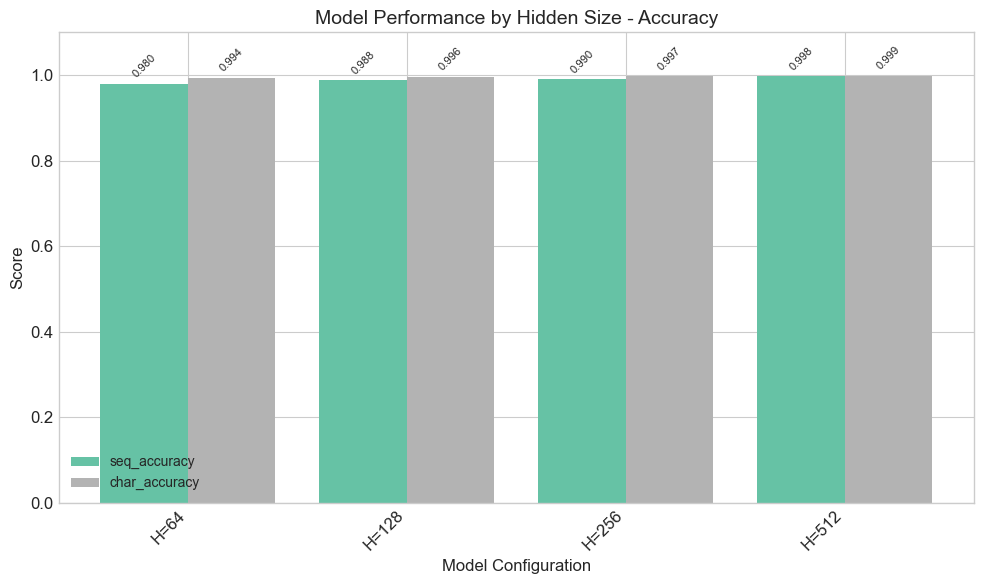

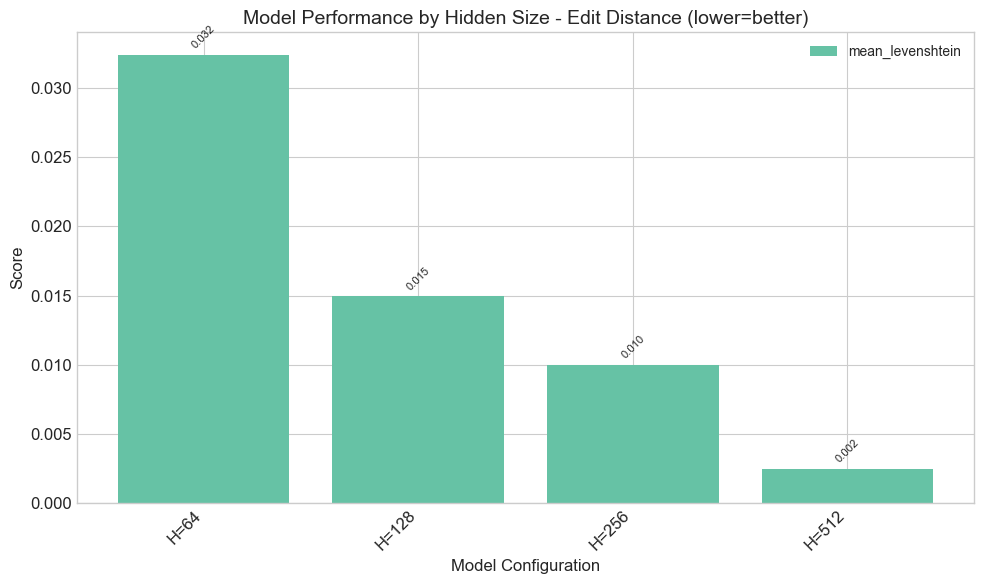


Parameter counts:
  H=64: 81,034 parameters
  H=128: 250,698 parameters
  H=256: 860,362 parameters
  H=512: 3,161,034 parameters


In [14]:
# Visualize hidden size comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    hidden_results,
    ['seq_accuracy', 'char_accuracy'],
    title='Model Performance by Hidden Size - Accuracy',
    save_path='figures/hidden_size_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    hidden_results,
    ['mean_levenshtein'],
    title='Model Performance by Hidden Size - Edit Distance (lower=better)',
    save_path='figures/hidden_size_comparison_levenshtein.png'
)
plt.show()
plt.show()

# Print parameter counts
print("\nParameter counts:")
for name, metrics in hidden_results.items():
    print(f"  {name}: {metrics.get('test_metrics', metrics).get('params', 'N/A'):,} parameters")

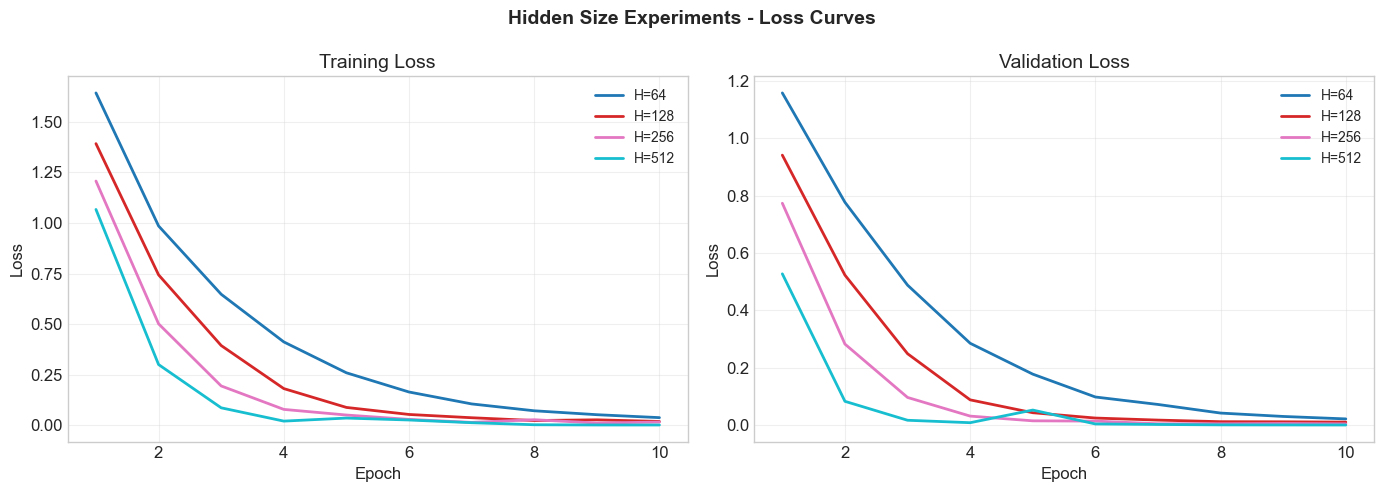

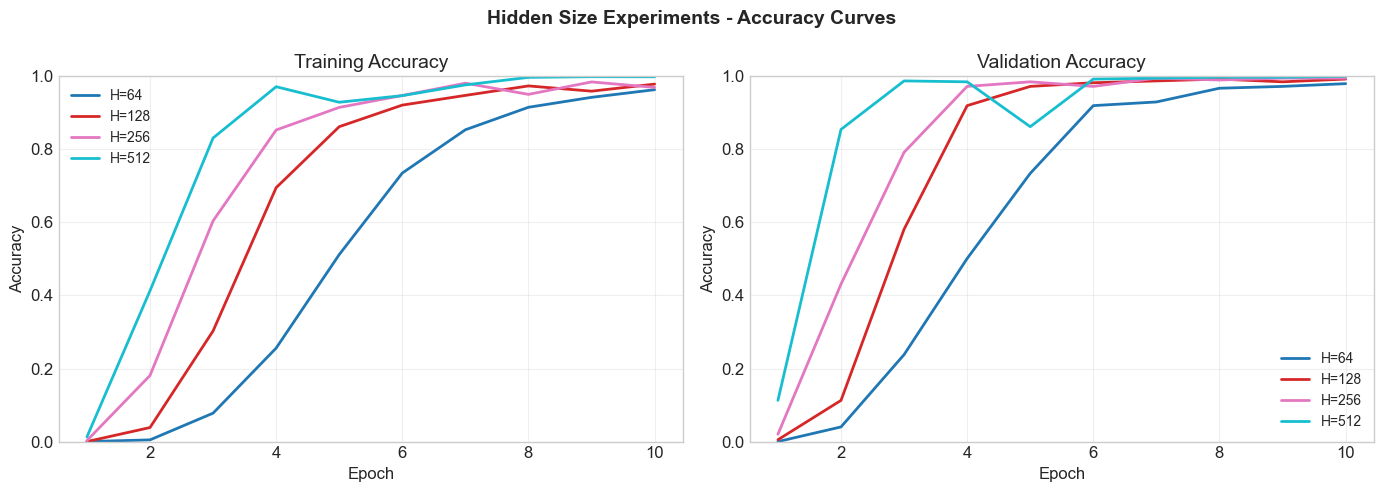

In [15]:
# Training curves for hidden size experiments
fig = plot_training_curves_comparison(
    hidden_results,
    metric='loss',
    title='Hidden Size Experiments - Loss Curves',
    save_path='figures/hidden_size_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    hidden_results,
    metric='accuracy',
    title='Hidden Size Experiments - Accuracy Curves',
    save_path='figures/hidden_size_acc_curves.png'
)
plt.show()

### 4.3 Architecture Parameters - Number of Layers

In [16]:
# Experiment with different number of layers
layer_results = {}

for num_layers in [1, 2, 3]:
    print(f"\n{'='*60}")
    print(f"Number of layers: {num_layers}")
    print('='*60)
    
    config = get_baseline_config()
    config.name = f"layers_{num_layers}"
    config.model.num_layers = num_layers
    config.model.dropout = 0.2 if num_layers > 1 else 0.1
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_dataset, val_dataset, test_dataset,
        src_vocab, tgt_vocab, device, verbose=True
    )
    layer_results[f"L={num_layers}"] = {'test_metrics': result['test_metrics'], 'history': result['history']}


Number of layers: 1
Experiment: layers_1
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Number of layers: 2
Experiment: layers_2
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 514,890
Loaded from epoch 10


Test Results:
  Loss: 0.0093 (±0.0028)
  Sequence Accuracy: 99.25% (±1.14%)
  Character Accuracy: 99.77%
  Mean Levenshtein Distance: 0.007
  Normalized Levenshtein: 0.0022
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Number of layers: 3
Experiment: layers_3
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 779,082
Loaded from epoch 10


Test Results:
  Loss: 0.0587 (±0.0088)
  Sequence Accuracy: 92.02% (±3.04%)
  Character Accuracy: 98.44%
  Mean Levenshtein Distance: 0.110
  Normalized Levenshtein: 0.0187
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


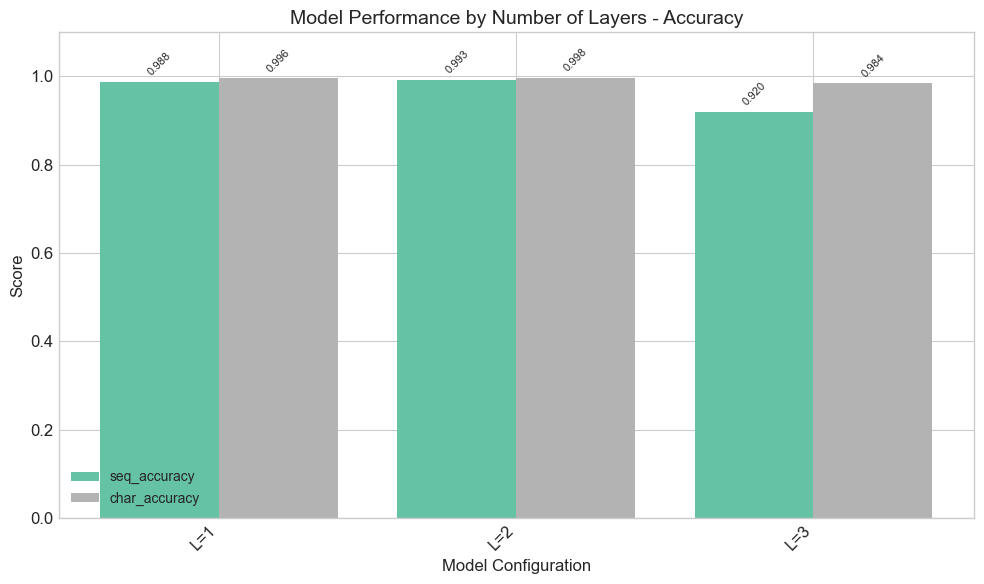

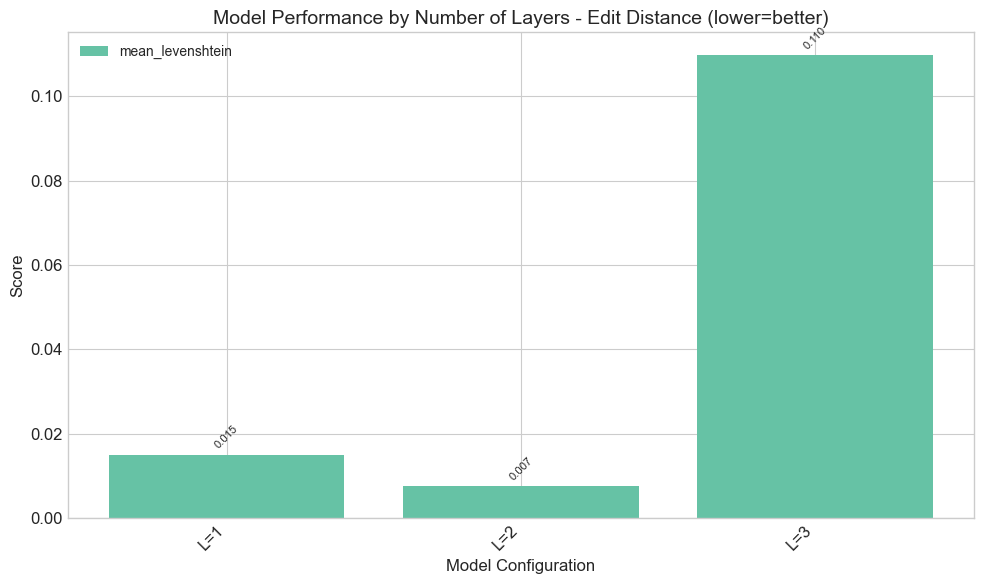

In [17]:
# Visualize layer comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    layer_results,
    ['seq_accuracy', 'char_accuracy'],
    title='Model Performance by Number of Layers - Accuracy',
    save_path='figures/layers_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    layer_results,
    ['mean_levenshtein'],
    title='Model Performance by Number of Layers - Edit Distance (lower=better)',
    save_path='figures/layers_comparison_levenshtein.png'
)
plt.show()
plt.show()

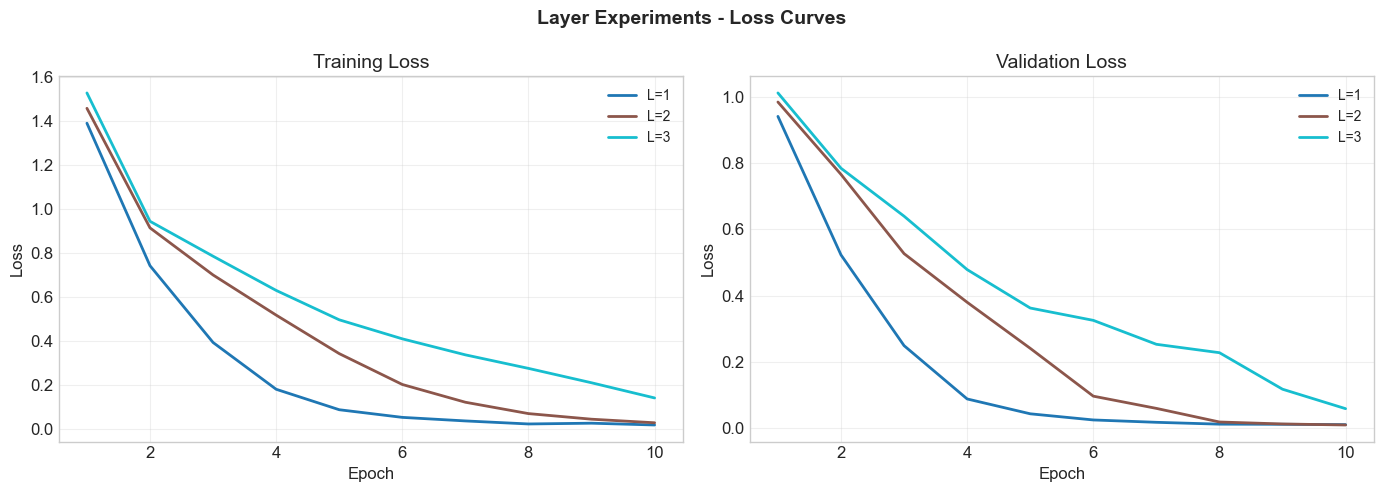

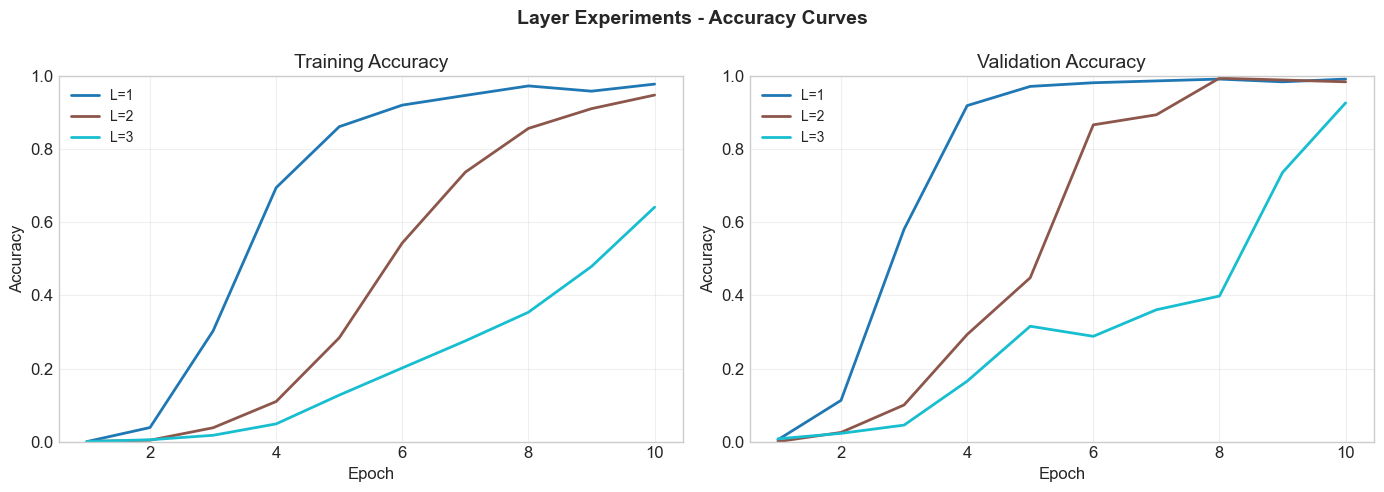

In [18]:
# Training curves for layer experiments
fig = plot_training_curves_comparison(
    layer_results,
    metric='loss',
    title='Layer Experiments - Loss Curves',
    save_path='figures/layers_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    layer_results,
    metric='accuracy',
    title='Layer Experiments - Accuracy Curves',
    save_path='figures/layers_acc_curves.png'
)
plt.show()

### 4.4 LSTM vs GRU Comparison

In [19]:
# Compare LSTM and GRU
cell_results = {}

for cell_type in ['lstm', 'gru']:
    print(f"\n{'='*60}")
    print(f"Cell type: {cell_type.upper()}")
    print('='*60)
    
    config = get_baseline_config()
    config.name = f"cell_{cell_type}"
    config.model.cell_type = cell_type
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_dataset, val_dataset, test_dataset,
        src_vocab, tgt_vocab, device, verbose=True
    )
    cell_results[cell_type.upper()] = {'test_metrics': result['test_metrics'], 'history': result['history']}
    cell_results[cell_type.upper()]['test_metrics']['params'] = count_parameters(result['model'])


Cell type: LSTM
Experiment: cell_lstm
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Cell type: GRU
Experiment: cell_gru
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 201,034
Loaded from epoch 10


Test Results:
  Loss: 0.0135 (±0.0051)
  Sequence Accuracy: 98.25% (±1.45%)
  Character Accuracy: 99.40%
  Mean Levenshtein Distance: 0.027
  Normalized Levenshtein: 0.0053
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


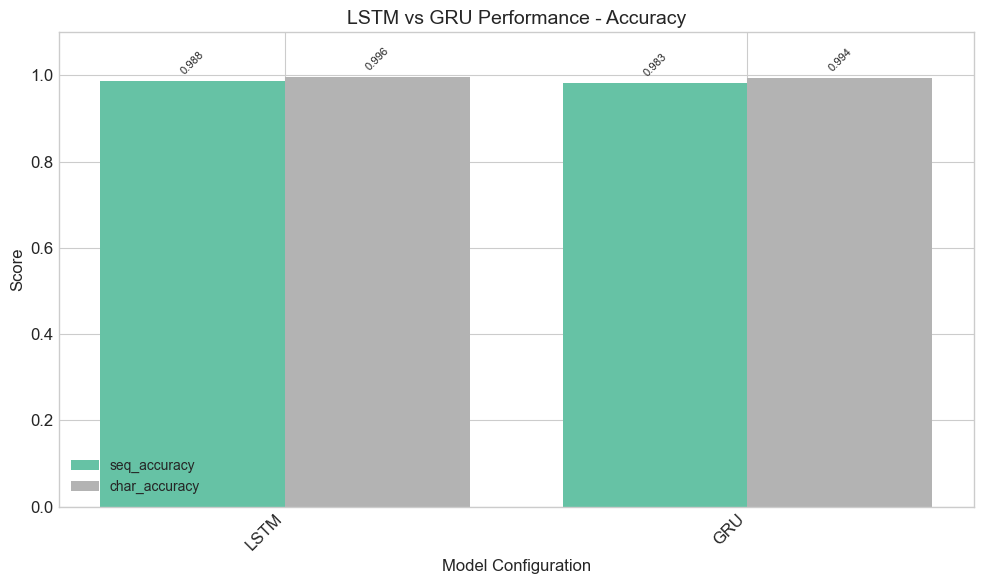

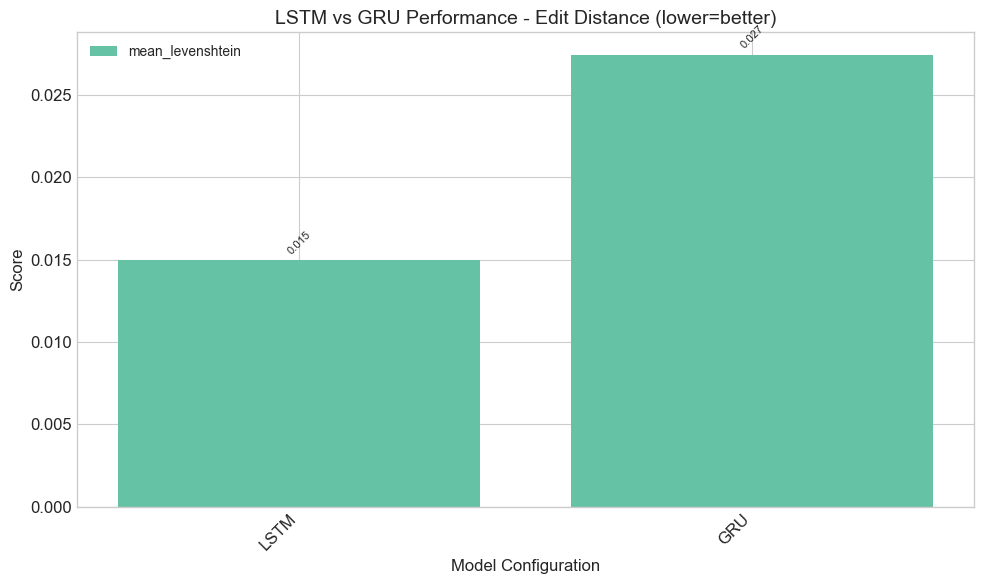

In [20]:
# Visualize cell type comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    cell_results,
    ['seq_accuracy', 'char_accuracy'],
    title='LSTM vs GRU Performance - Accuracy',
    save_path='figures/cell_type_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    cell_results,
    ['mean_levenshtein'],
    title='LSTM vs GRU Performance - Edit Distance (lower=better)',
    save_path='figures/cell_type_comparison_levenshtein.png'
)
plt.show()
plt.show()

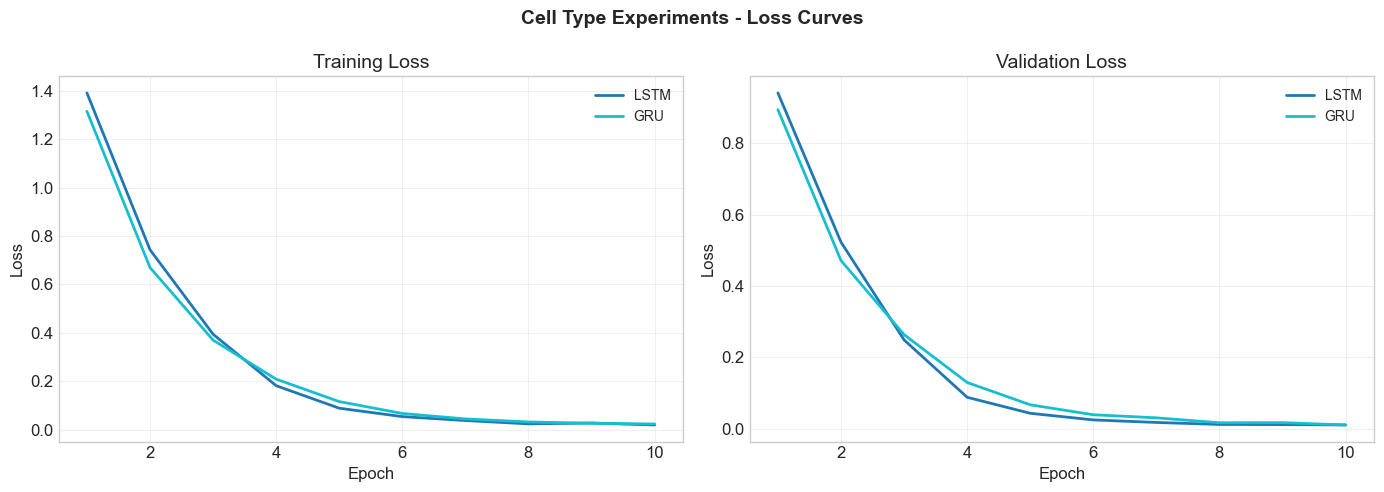

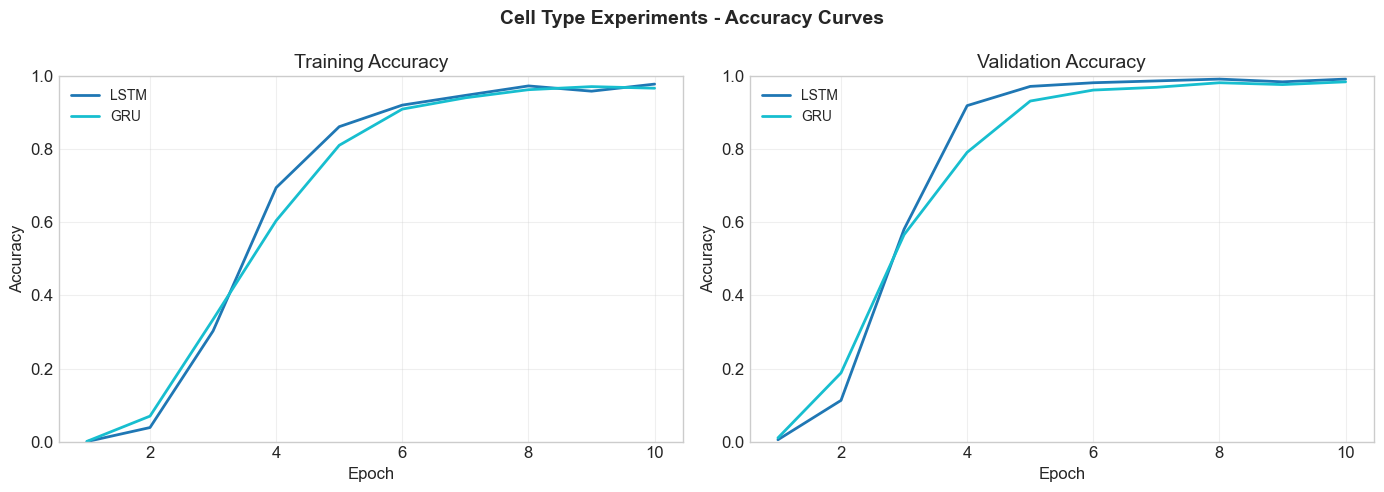

In [21]:
# Training curves for cell type experiments
fig = plot_training_curves_comparison(
    cell_results,
    metric='loss',
    title='Cell Type Experiments - Loss Curves',
    save_path='figures/cell_type_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    cell_results,
    metric='accuracy',
    title='Cell Type Experiments - Accuracy Curves',
    save_path='figures/cell_type_acc_curves.png'
)
plt.show()

### 4.5 Bidirectional vs Unidirectional Encoder

In [22]:
# Compare bidirectional and unidirectional
direction_results = {}

for bidirectional in [False, True]:
    name = 'Bidirectional' if bidirectional else 'Unidirectional'
    print(f"\n{'='*60}")
    print(f"Encoder: {name}")
    print('='*60)
    
    config = get_baseline_config()
    config.name = f"bidir_{bidirectional}"
    config.model.bidirectional = bidirectional
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_dataset, val_dataset, test_dataset,
        src_vocab, tgt_vocab, device, verbose=True
    )
    direction_results[name] = {'test_metrics': result['test_metrics'], 'history': result['history']}


Encoder: Unidirectional
Experiment: bidir_False
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Encoder: Bidirectional
Experiment: bidir_True
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 448,586
Loaded from epoch 10


Test Results:
  Loss: 0.0085 (±0.0068)
  Sequence Accuracy: 99.50% (±0.71%)
  Character Accuracy: 99.80%
  Mean Levenshtein Distance: 0.007
  Normalized Levenshtein: 0.0021
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


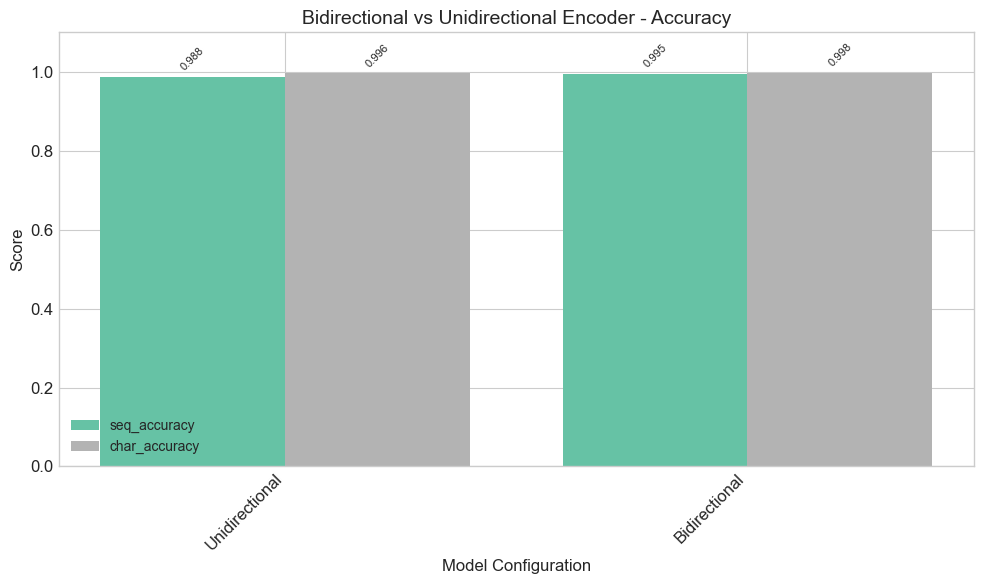

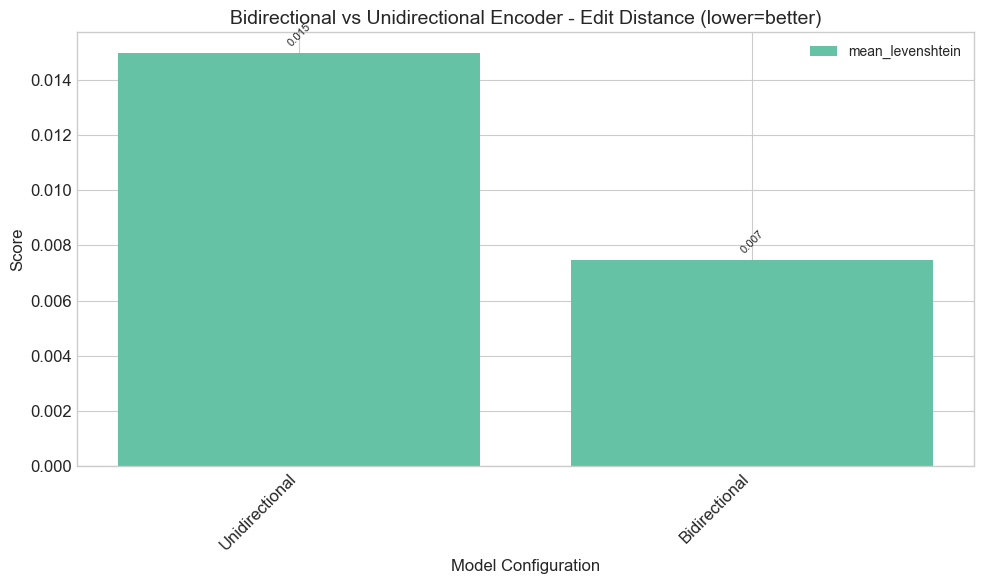

In [23]:
# Visualize direction comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    direction_results,
    ['seq_accuracy', 'char_accuracy'],
    title='Bidirectional vs Unidirectional Encoder - Accuracy',
    save_path='figures/direction_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    direction_results,
    ['mean_levenshtein'],
    title='Bidirectional vs Unidirectional Encoder - Edit Distance (lower=better)',
    save_path='figures/direction_comparison_levenshtein.png'
)
plt.show()
plt.show()

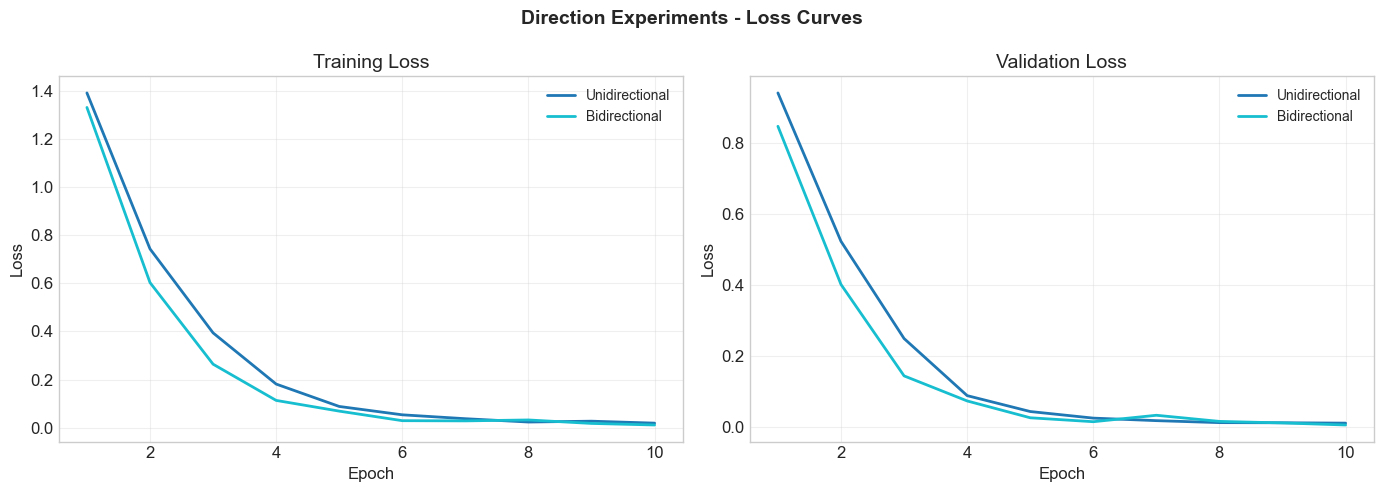

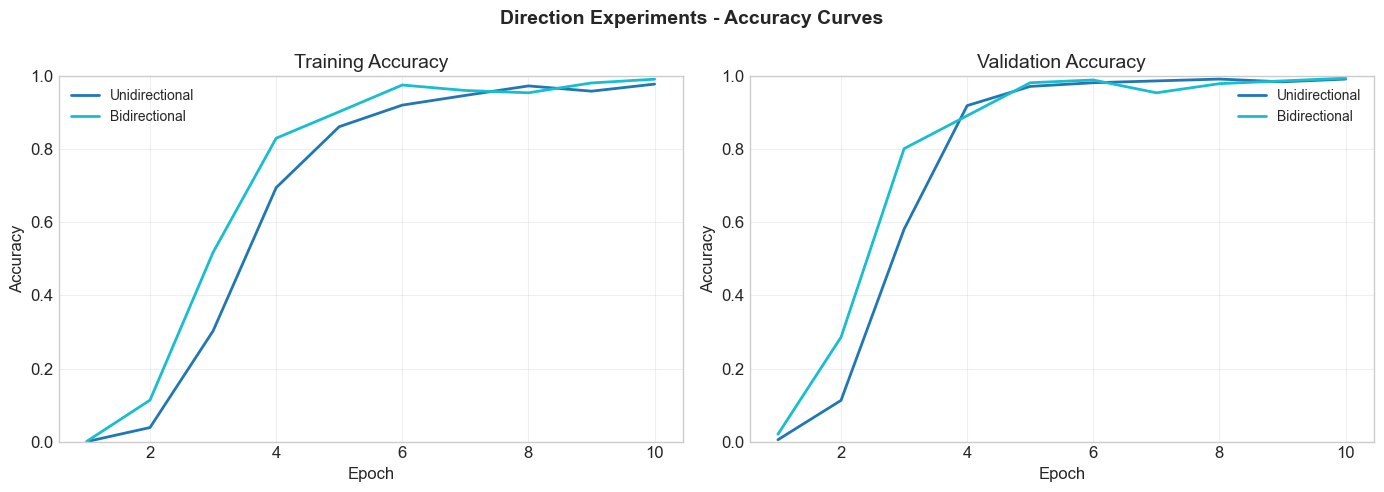

In [24]:
# Training curves for direction experiments
fig = plot_training_curves_comparison(
    direction_results,
    metric='loss',
    title='Direction Experiments - Loss Curves',
    save_path='figures/direction_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    direction_results,
    metric='accuracy',
    title='Direction Experiments - Accuracy Curves',
    save_path='figures/direction_acc_curves.png'
)
plt.show()

### 4.6 Embedding Types (Learned vs One-hot)

In [25]:
# Compare embedding types
embed_results = {}

for embed_type in ['learned', 'onehot']:
    print(f"\n{'='*60}")
    print(f"Embedding type: {embed_type}")
    print('='*60)
    
    config = get_baseline_config()
    config.name = f"embed_{embed_type}"
    config.model.embedding_type = embed_type
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_dataset, val_dataset, test_dataset,
        src_vocab, tgt_vocab, device, verbose=True
    )
    embed_results[embed_type.capitalize()] = {'test_metrics': result['test_metrics'], 'history': result['history']}


Embedding type: learned
Experiment: embed_learned
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Embedding type: onehot
Experiment: embed_onehot
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 195,466
Loaded from epoch 10


Test Results:
  Loss: 0.4382 (±0.0265)
  Sequence Accuracy: 19.95% (±6.80%)
  Character Accuracy: 76.41%
  Mean Levenshtein Distance: 1.566
  Normalized Levenshtein: 0.2187
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [X] pred: MMMCMXI | target: MMMCCIX
    [X] pred: MMCMXXXII | target: MMCMXCIII
    [X] pred: MMDCCCLXVI | target: MMDCCCLIV


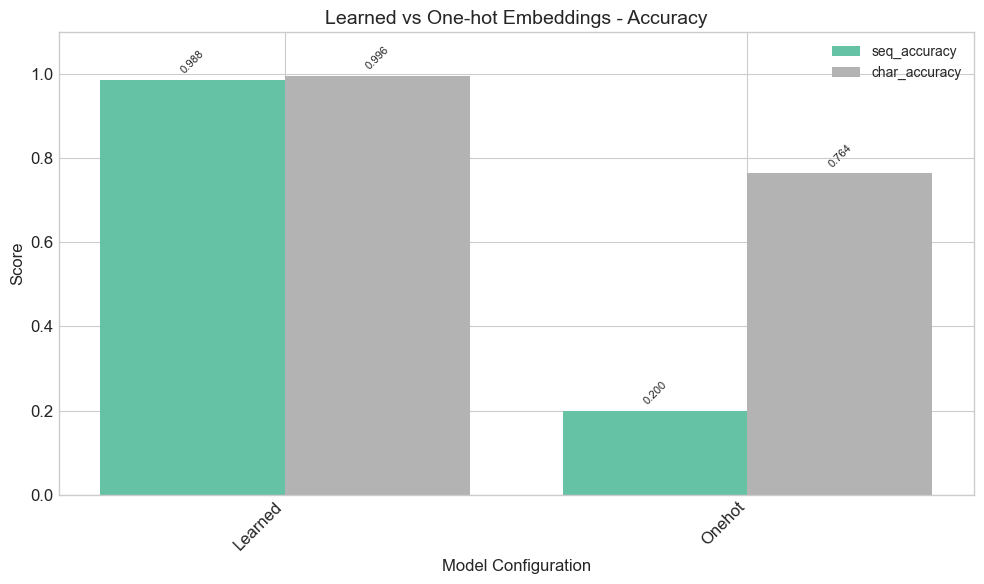

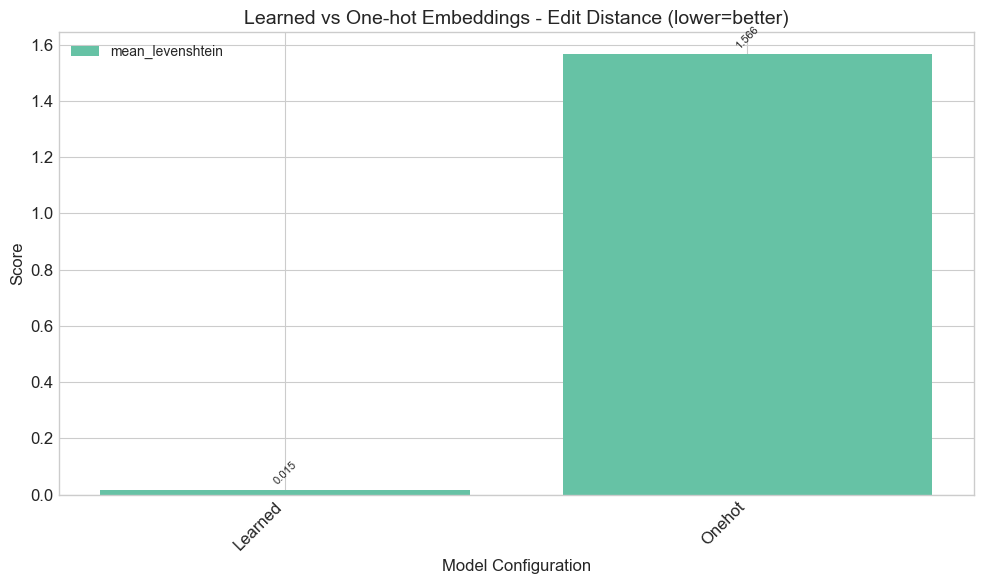

In [26]:
# Visualize embedding comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    embed_results,
    ['seq_accuracy', 'char_accuracy'],
    title='Learned vs One-hot Embeddings - Accuracy',
    save_path='figures/embedding_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    embed_results,
    ['mean_levenshtein'],
    title='Learned vs One-hot Embeddings - Edit Distance (lower=better)',
    save_path='figures/embedding_comparison_levenshtein.png'
)
plt.show()
plt.show()

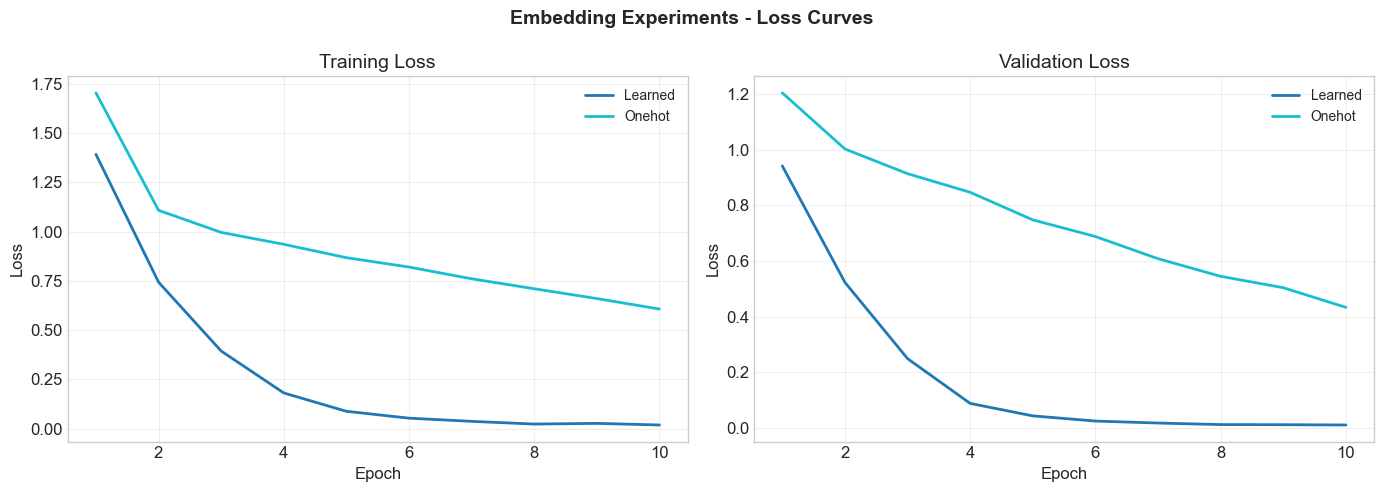

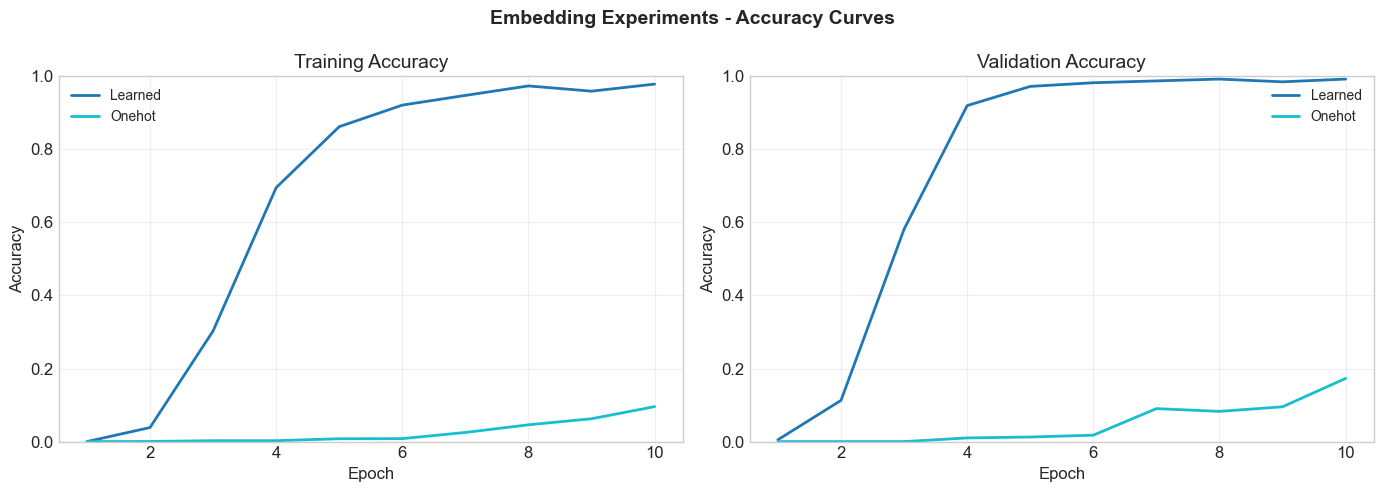

In [27]:
# Training curves for embedding experiments
fig = plot_training_curves_comparison(
    embed_results,
    metric='loss',
    title='Embedding Experiments - Loss Curves',
    save_path='figures/embedding_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    embed_results,
    metric='accuracy',
    title='Embedding Experiments - Accuracy Curves',
    save_path='figures/embedding_acc_curves.png'
)
plt.show()

### 4.7 Attention Methods

In [28]:
# Compare attention methods
attention_results = {}

for method in ['dot', 'general', 'concat']:
    print(f"\n{'='*60}")
    print(f"Attention method: {method}")
    print('='*60)
    
    config = get_baseline_config()
    config.name = f"attention_{method}"
    config.model.attention_method = method
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_dataset, val_dataset, test_dataset,
        src_vocab, tgt_vocab, device, verbose=True
    )
    attention_results[method.capitalize()] = {'test_metrics': result['test_metrics'], 'history': result['history']}


Attention method: dot
Experiment: attention_dot
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 234,314
Loaded from epoch 10


Test Results:
  Loss: 0.0140 (±0.0073)
  Sequence Accuracy: 99.00% (±0.77%)
  Character Accuracy: 99.67%
  Mean Levenshtein Distance: 0.022
  Normalized Levenshtein: 0.0053
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Attention method: general
Experiment: attention_general
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0155 (±0.0092)
  Sequence Accuracy: 98.75% (±2.01%)
  Character Accuracy: 99.64%
  Mean Levenshtein Distance: 0.015
  Normalized Levenshtein: 0.0036
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Attention method: concat
Experiment: attention_concat
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 267,210
Loaded from epoch 10


Test Results:
  Loss: 0.0075 (±0.0043)
  Sequence Accuracy: 99.25% (±2.00%)
  Character Accuracy: 99.80%
  Mean Levenshtein Distance: 0.007
  Normalized Levenshtein: 0.0021
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


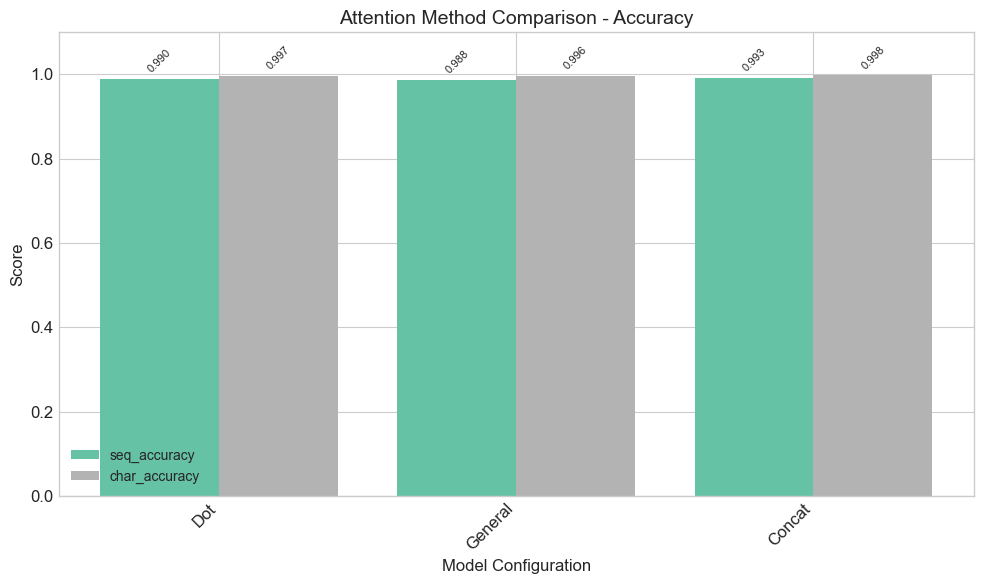

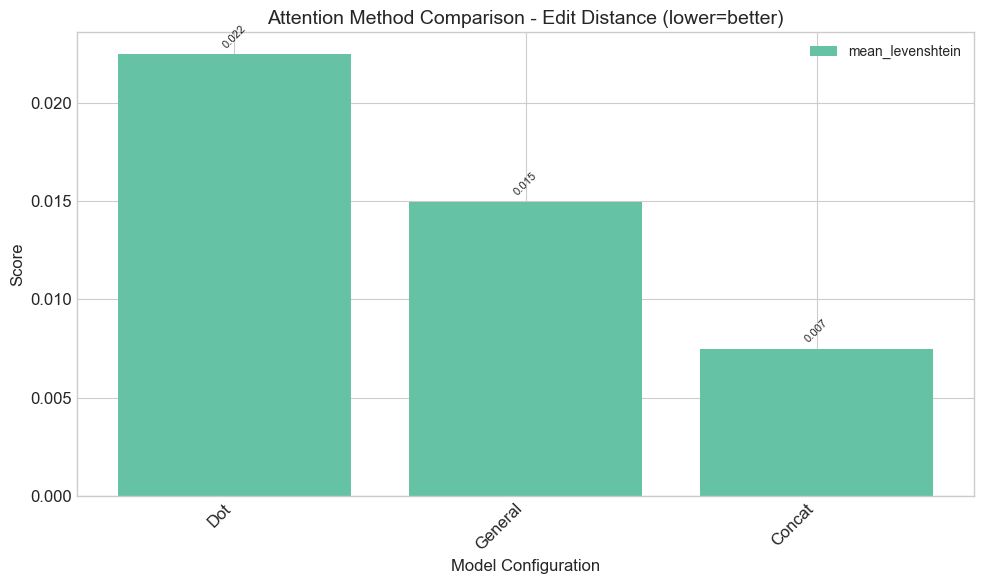

In [29]:
# Visualize attention comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    attention_results,
    ['seq_accuracy', 'char_accuracy'],
    title='Attention Method Comparison - Accuracy',
    save_path='figures/attention_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    attention_results,
    ['mean_levenshtein'],
    title='Attention Method Comparison - Edit Distance (lower=better)',
    save_path='figures/attention_comparison_levenshtein.png'
)
plt.show()
plt.show()

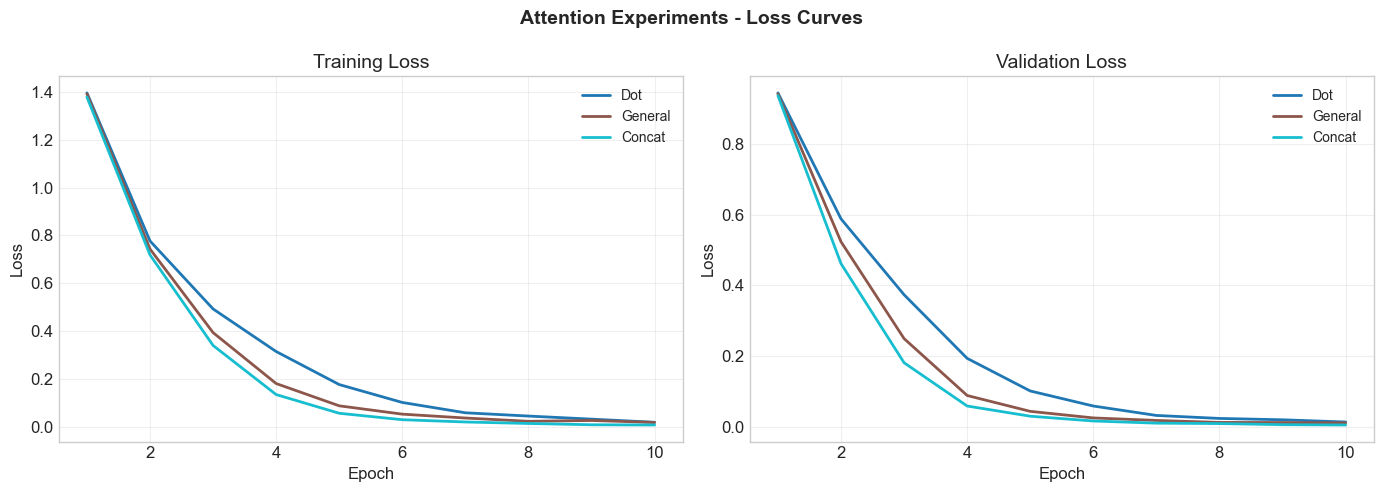

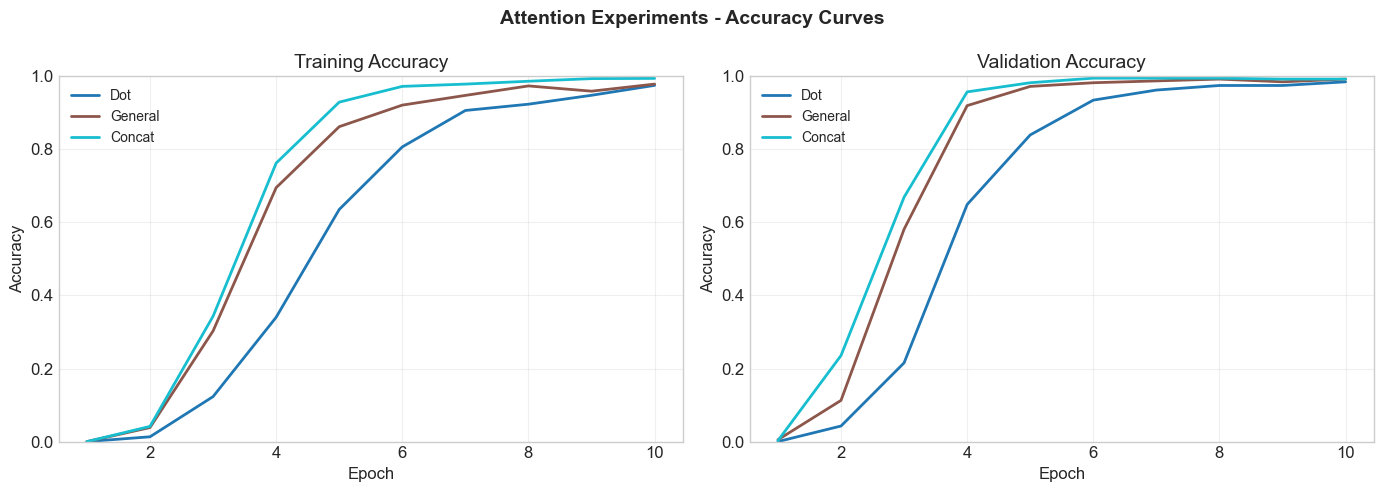

In [30]:
# Training curves for attention experiments
fig = plot_training_curves_comparison(
    attention_results,
    metric='loss',
    title='Attention Experiments - Loss Curves',
    save_path='figures/attention_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    attention_results,
    metric='accuracy',
    title='Attention Experiments - Accuracy Curves',
    save_path='figures/attention_acc_curves.png'
)
plt.show()

### 4.8 Regularization - Dropout

In [31]:
# Compare dropout rates
dropout_results = {}

for dropout in [0.0, 0.2, 0.4]:
    print(f"\n{'='*60}")
    print(f"Dropout: {dropout}")
    print('='*60)
    
    config = get_baseline_config()
    config.name = f"dropout_{dropout}"
    config.model.dropout = dropout
    config.training.epochs = 10
    
    result = run_experiment(
        config, train_dataset, val_dataset, test_dataset,
        src_vocab, tgt_vocab, device, verbose=True
    )
    dropout_results[f"p={dropout}"] = {'test_metrics': result['test_metrics'], 'history': result['history']}


Dropout: 0.0
Experiment: dropout_0.0
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 10


Test Results:
  Loss: 0.0072 (±0.0045)
  Sequence Accuracy: 99.50% (±0.71%)
  Character Accuracy: 99.80%
  Mean Levenshtein Distance: 0.007
  Normalized Levenshtein: 0.0021
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Dropout: 0.2
Experiment: dropout_0.2
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 9


Test Results:
  Loss: 0.0138 (±0.0060)
  Sequence Accuracy: 98.75% (±2.33%)
  Character Accuracy: 99.30%
  Mean Levenshtein Distance: 0.032
  Normalized Levenshtein: 0.0052
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV

Dropout: 0.4
Experiment: dropout_0.4
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 250,698
Loaded from epoch 9


Test Results:
  Loss: 0.0154 (±0.0066)
  Sequence Accuracy: 99.50% (±0.71%)
  Character Accuracy: 99.80%
  Mean Levenshtein Distance: 0.007
  Normalized Levenshtein: 0.0021
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


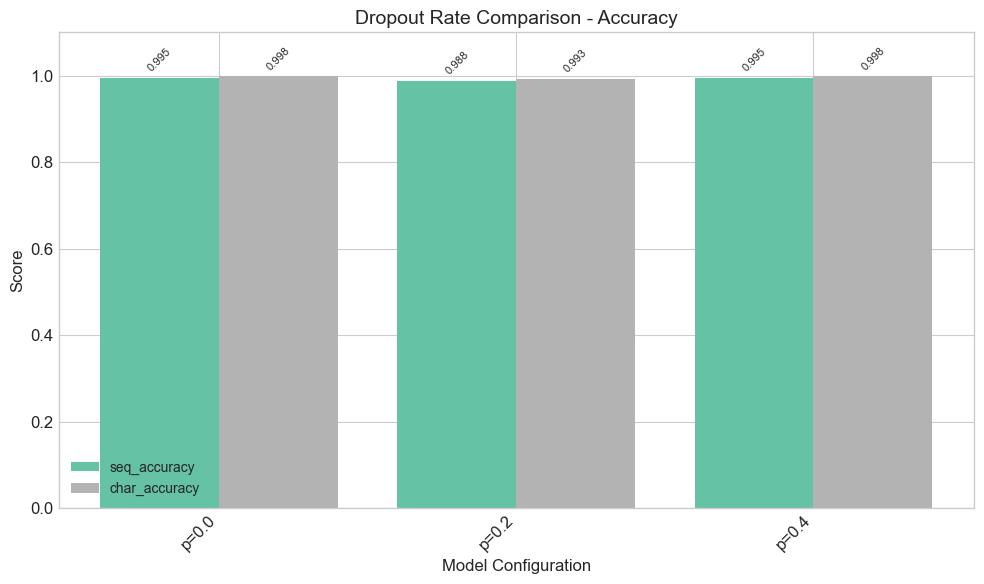

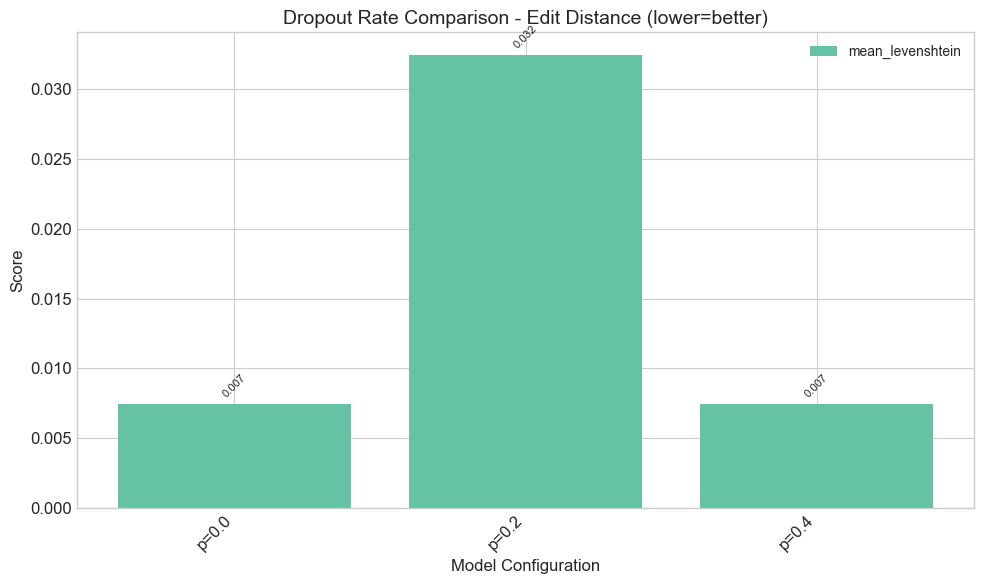

In [32]:
# Visualize dropout comparison
# Accuracy comparison
fig = plot_metrics_comparison(
    dropout_results,
    ['seq_accuracy', 'char_accuracy'],
    title='Dropout Rate Comparison - Accuracy',
    save_path='figures/dropout_comparison_accuracy.png'
)
plt.show()

# Levenshtein distance comparison (lower is better)
fig = plot_metrics_comparison(
    dropout_results,
    ['mean_levenshtein'],
    title='Dropout Rate Comparison - Edit Distance (lower=better)',
    save_path='figures/dropout_comparison_levenshtein.png'
)
plt.show()
plt.show()

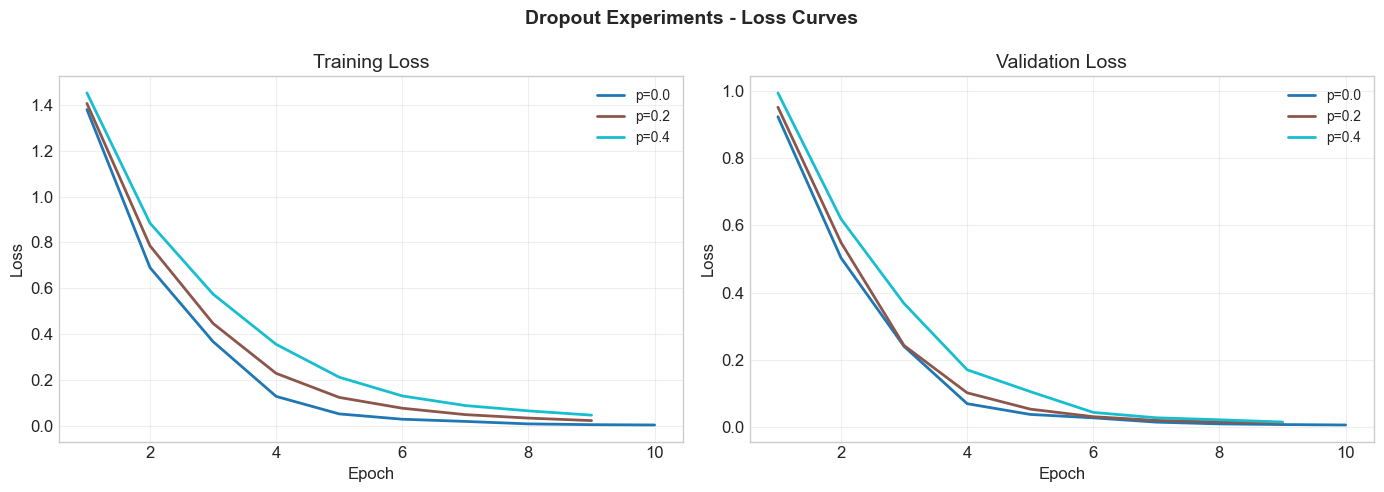

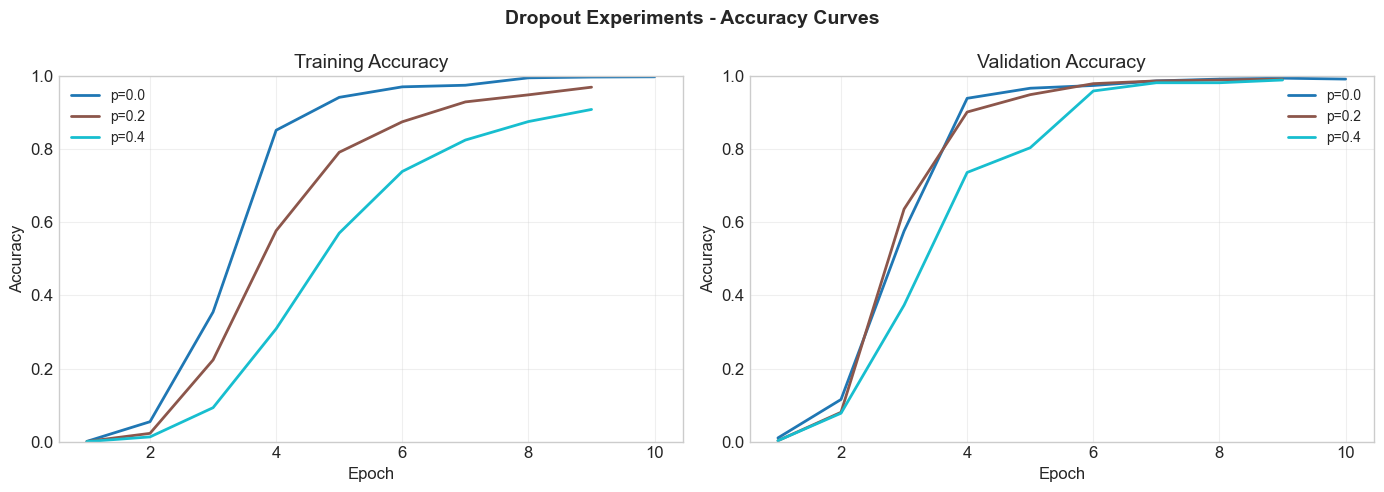

In [33]:
# Training curves for dropout experiments
fig = plot_training_curves_comparison(
    dropout_results,
    metric='loss',
    title='Dropout Experiments - Loss Curves',
    save_path='figures/dropout_loss_curves.png'
)
plt.show()

fig = plot_training_curves_comparison(
    dropout_results,
    metric='accuracy',
    title='Dropout Experiments - Accuracy Curves',
    save_path='figures/dropout_acc_curves.png'
)
plt.show()

## 5. Decoding Strategies Comparison

In [34]:
# Train a good model for decoding comparison
print("Training model for decoding comparison...")
config = get_baseline_config()
config.name = "decoding_test"
config.model.hidden_size = 256
config.model.bidirectional = True
config.training.epochs = 10

decode_result = run_experiment(
    config, train_dataset, val_dataset, test_dataset,
    src_vocab, tgt_vocab, device, verbose=True
)
decode_model = decode_result['model']

Training model for decoding comparison...
Experiment: decoding_test
[RESUME] Found existing checkpoint, skipping training...
Model parameters: 1,583,818
Loaded from epoch 6


Test Results:
  Loss: 0.0210 (±0.0109)
  Sequence Accuracy: 97.26% (±1.84%)
  Character Accuracy: 99.11%
  Mean Levenshtein Distance: 0.032
  Normalized Levenshtein: 0.0059
Sample Predictions:
    [OK] pred: MMDCCXII | target: MMDCCXII
    [OK] pred: MMCCLXXVII | target: MMCCLXXVII
    [OK] pred: MMMCCIX | target: MMMCCIX
    [OK] pred: MMCMXCIII | target: MMCMXCIII
    [OK] pred: MMDCCCLIV | target: MMDCCCLIV


In [35]:
# Compare decoding strategies
test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=64
)[2]

decoding_results = {}
decoding_configs = get_decoding_configs()

for dec_config in decoding_configs:
    strategy = dec_config['strategy']
    params = {k: v for k, v in dec_config.items() if k != 'strategy'}
    
    name = strategy
    if params:
        name += '_' + '_'.join(f"{k}={v}" for k, v in params.items())
    
    print(f"Testing: {name}")
    
    all_preds = []
    all_targets = []
    
    decode_model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=name, leave=False):
            src = batch['src'].to(device)
            src_lengths = batch['src_len'].to(device)
            max_len = batch['tgt'].size(1)
            
            pred_indices, _ = decode_with_strategy(
                decode_model, src, src_lengths, max_len,
                strategy=strategy, **params
            )
            
            for i in range(src.size(0)):
                pred = tgt_vocab.decode(pred_indices[i])
                all_preds.append(pred)
                all_targets.append(batch['roman_str'][i])
    
    metrics = calculate_metrics(all_preds, all_targets)
    decoding_results[name] = metrics
    print(f"  Seq Acc: {metrics['seq_accuracy']:.2%}, Char Acc: {metrics['char_accuracy']:.2%}")

Testing: greedy


  Seq Acc: 97.26%, Char Acc: 99.11%
Testing: beam_beam_size=3


  Seq Acc: 98.25%, Char Acc: 99.50%
Testing: beam_beam_size=5


  Seq Acc: 98.25%, Char Acc: 99.50%
Testing: beam_beam_size=10


  Seq Acc: 98.25%, Char Acc: 99.50%
Testing: top_k_k=3_temperature=1.0


  Seq Acc: 90.27%, Char Acc: 96.64%
Testing: top_k_k=5_temperature=1.0


  Seq Acc: 90.52%, Char Acc: 96.55%
Testing: top_k_k=5_temperature=0.7


  Seq Acc: 95.01%, Char Acc: 98.22%
Testing: top_p_p=0.9_temperature=1.0


  Seq Acc: 94.01%, Char Acc: 98.15%
Testing: top_p_p=0.95_temperature=1.0


  Seq Acc: 93.77%, Char Acc: 97.82%
Testing: top_p_p=0.9_temperature=0.7


  Seq Acc: 96.26%, Char Acc: 98.78%


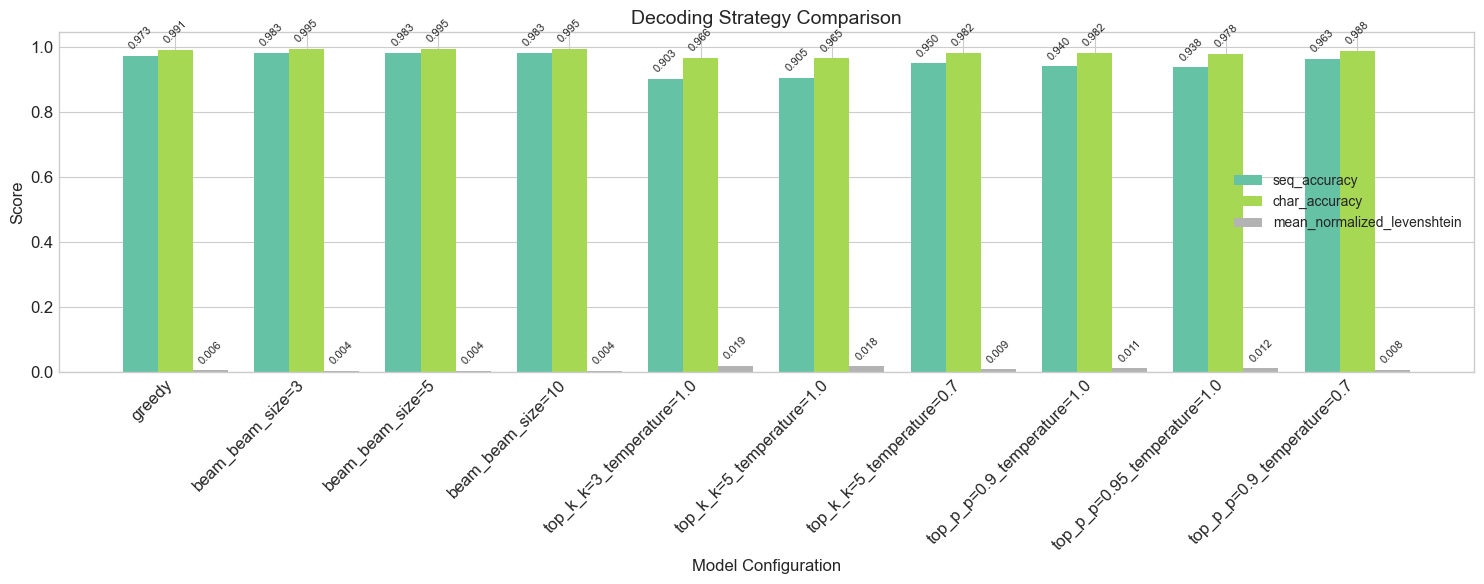

In [36]:
# Visualize decoding comparison
fig = plot_decoding_comparison(
    decoding_results,
    save_path='figures/decoding_comparison.png'
)
plt.show()

## 6. Attention Visualization

Small Numbers (Simple Patterns)
4 -> Predicted: IV, Target: IV, Match: True
9 -> Predicted: XIX, Target: IX, Match: False
42 -> Predicted: XLII, Target: XLII, Match: True
99 -> Predicted: XCIX, Target: XCIX, Match: True


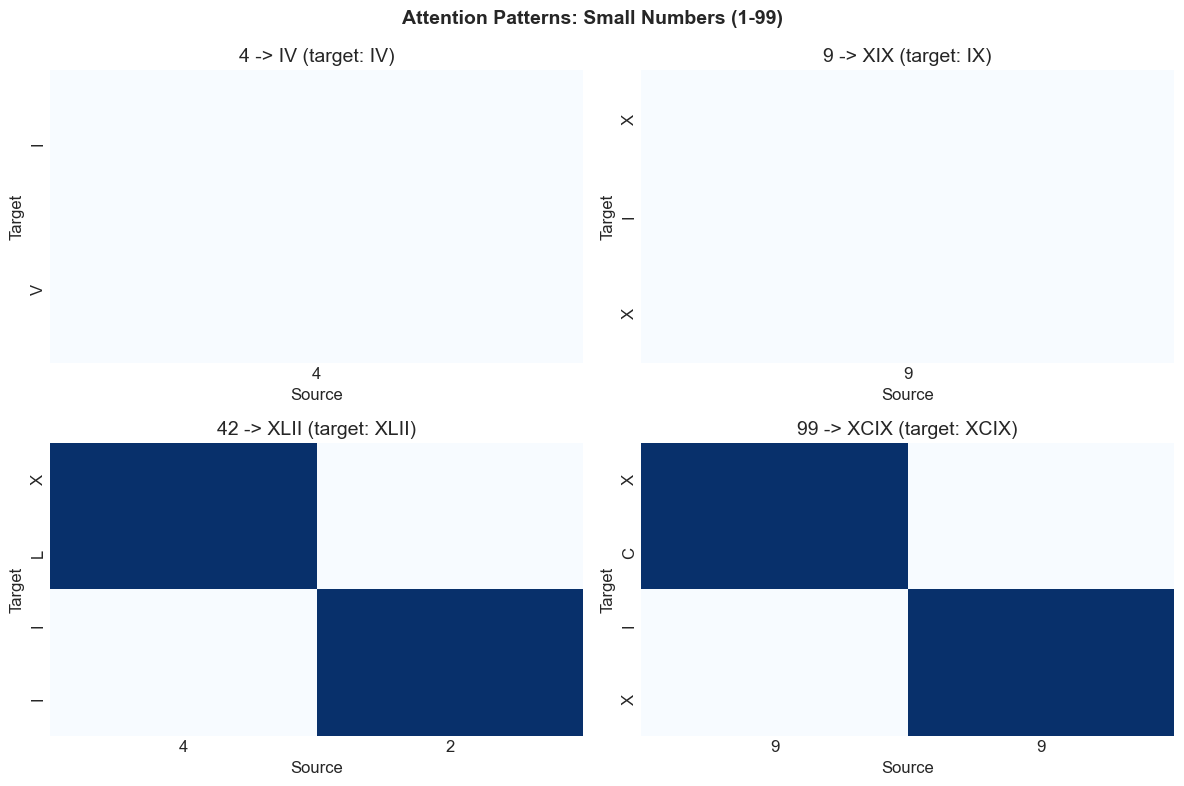


Medium Numbers (Moderate Complexity)
123 -> Predicted: CXXIII, Target: CXXIII, Match: True
888 -> Predicted: DCCCLXXXVIII, Target: DCCCLXXXVIII, Match: True
1999 -> Predicted: MCMXCIX, Target: MCMXCIX, Match: True
3888 -> Predicted: MMMDCCCLXXXVIII, Target: MMMDCCCLXXXVIII, Match: True


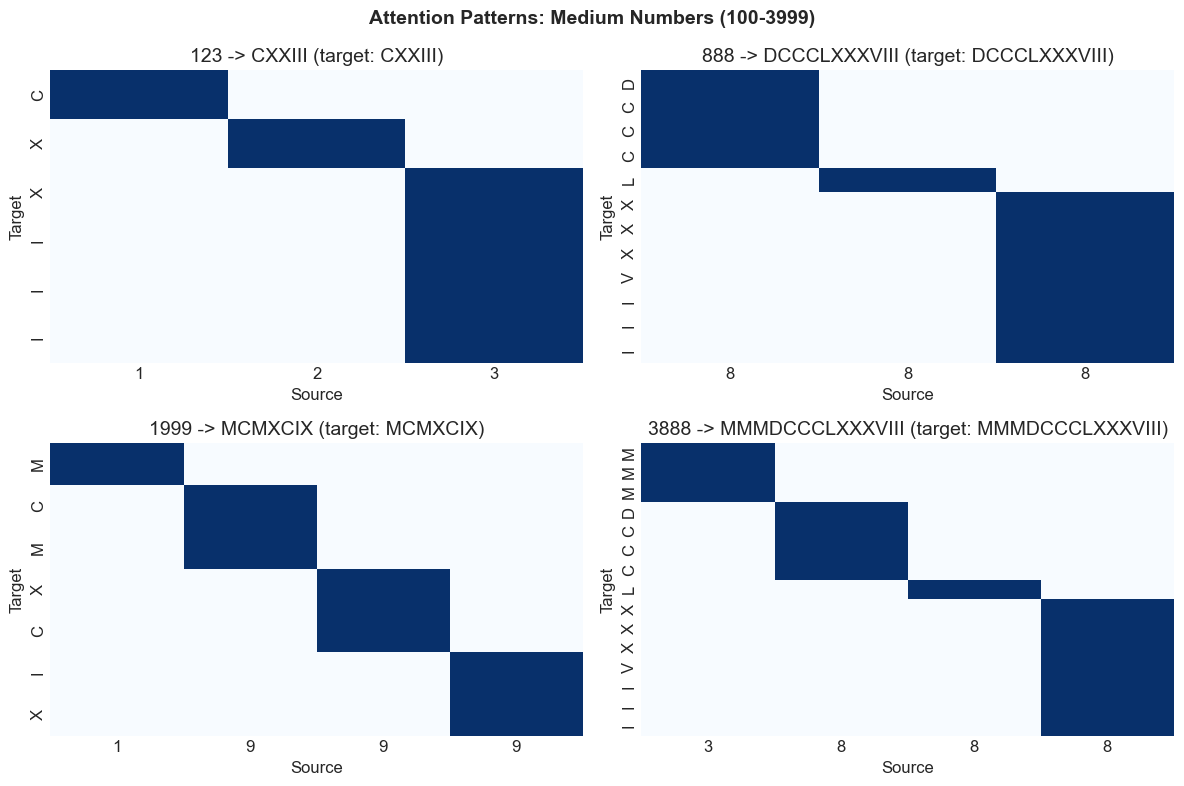


Large Numbers (Complex Patterns with Vinculum)
12345 -> Predicted: MMCCCXXXV, Target: _X_I_ICCCXLV, Match: False
50000 -> Predicted: MDX, Target: _L, Match: False
123456 -> Predicted: MMCCCXCVI, Target: _C_X_X_I_I_ICDLVI, Match: False
249999 -> Predicted: MMMCMXCIX, Target: _C_C_X_L_I_XCMXCIX, Match: False


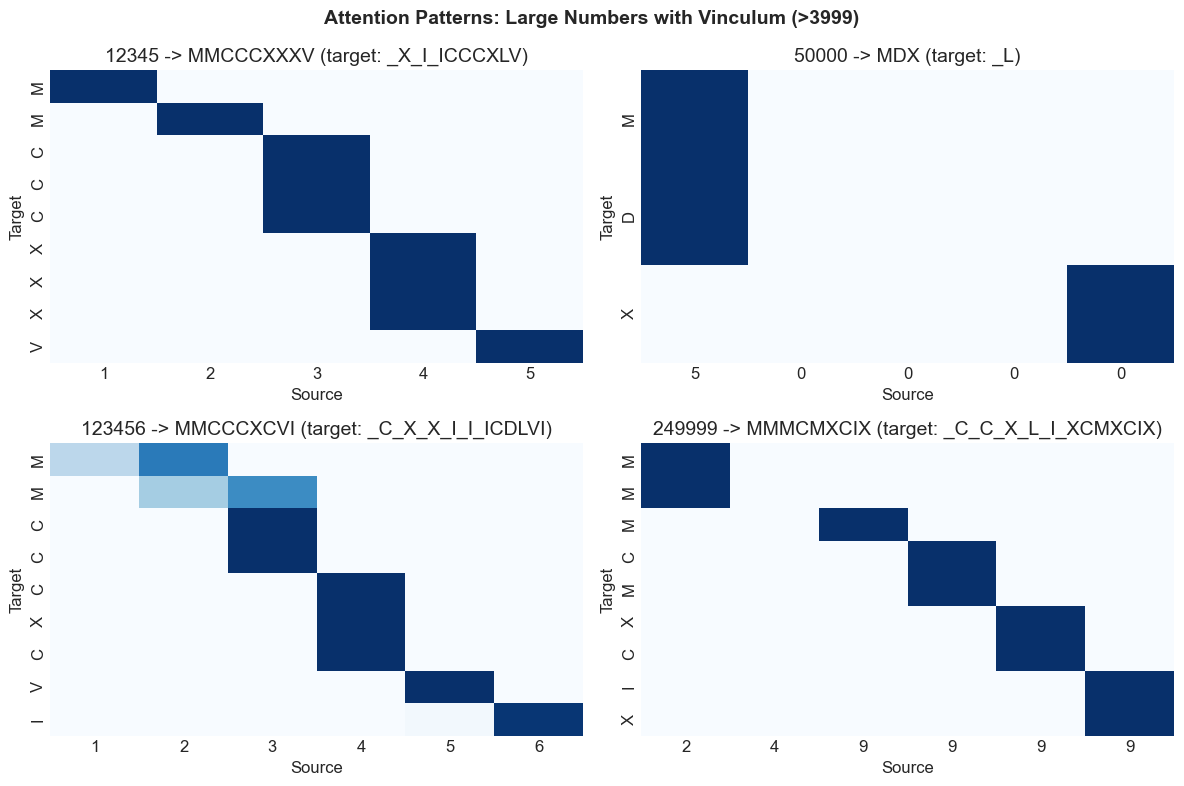


Attention visualizations saved to figures/


In [37]:
# Get attention weights for sample inputs - 3 separate figures with different complexity levels

def get_attention_examples(numbers, model, src_vocab, tgt_vocab, device):
    """Get attention examples for a list of numbers."""
    examples = []
    model.eval()
    for num in numbers:
        decimal_str = str(num)
        roman_str = decimal_to_roman(num)
        
        # Prepare input
        src_indices = src_vocab.encode(decimal_str)
        src_tensor = torch.tensor([src_indices], dtype=torch.long, device=device)
        src_len = torch.tensor([len(src_indices)], device=device)
        
        # Get predictions with attention
        with torch.no_grad():
            pred_indices, attn_weights = greedy_decode(
                model, src_tensor, src_len, 30,
                tgt_vocab.sos_idx, tgt_vocab.eos_idx
            )
        
        pred_str = tgt_vocab.decode(pred_indices[0])
        
        examples.append({
            'attention': attn_weights[0],
            'src_tokens': list(decimal_str),
            'tgt_tokens': list(pred_str),
            'title': f"{num} -> {pred_str} (target: {roman_str})"
        })
        
        print(f"{num} -> Predicted: {pred_str}, Target: {roman_str}, Match: {pred_str == roman_str}")
    
    return examples

# Figure 1: Small numbers (1-2 digits) - Simple patterns
print("=" * 60)
print("Small Numbers (Simple Patterns)")
print("=" * 60)
small_numbers = [4, 9, 42, 99]
small_examples = get_attention_examples(small_numbers, decode_model, src_vocab, tgt_vocab, device)

fig1 = plot_multiple_attention(
    small_examples,
    ncols=2,
    save_path='figures/attention_heatmaps_small.png'
)
plt.suptitle('Attention Patterns: Small Numbers (1-99)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Figure 2: Medium numbers (3-4 digits) - Moderate complexity
print("\n" + "=" * 60)
print("Medium Numbers (Moderate Complexity)")
print("=" * 60)
medium_numbers = [123, 888, 1999, 3888]
medium_examples = get_attention_examples(medium_numbers, decode_model, src_vocab, tgt_vocab, device)

fig2 = plot_multiple_attention(
    medium_examples,
    ncols=2,
    save_path='figures/attention_heatmaps_medium.png'
)
plt.suptitle('Attention Patterns: Medium Numbers (100-3999)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Figure 3: Large numbers (5-6 digits) - Complex patterns with vinculum notation
print("\n" + "=" * 60)
print("Large Numbers (Complex Patterns with Vinculum)")
print("=" * 60)
large_numbers = [12345, 50000, 123456, 249999]
large_examples = get_attention_examples(large_numbers, decode_model, src_vocab, tgt_vocab, device)

fig3 = plot_multiple_attention(
    large_examples,
    ncols=2,
    save_path='figures/attention_heatmaps_large.png'
)
plt.suptitle('Attention Patterns: Large Numbers with Vinculum (>3999)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nAttention visualizations saved to figures/")

## 7. Error Analysis

In [38]:
# Get predictions and analyze errors on BOTH train and test sets
train_loader, _, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=64
)

# Test set predictions
test_preds = []
test_targets = []
test_decimals = []

decode_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Analyzing test set'):
        src = batch['src'].to(device)
        src_lengths = batch['src_len'].to(device)
        max_len = batch['tgt'].size(1)
        
        pred_indices, _ = greedy_decode(
            decode_model, src, src_lengths, max_len,
            tgt_vocab.sos_idx, tgt_vocab.eos_idx
        )
        
        for i in range(src.size(0)):
            pred = tgt_vocab.decode(pred_indices[i])
            test_preds.append(pred)
            test_targets.append(batch['roman_str'][i])
            test_decimals.append(batch['decimal'][i].item())

# Training set predictions (sample for efficiency - use first 50000)
train_preds = []
train_targets = []
train_decimals = []
max_train_samples = 50000
samples_collected = 0

with torch.no_grad():
    for batch in tqdm(train_loader, desc='Analyzing train set'):
        if samples_collected >= max_train_samples:
            break
        src = batch['src'].to(device)
        src_lengths = batch['src_len'].to(device)
        max_len = batch['tgt'].size(1)
        
        pred_indices, _ = greedy_decode(
            decode_model, src, src_lengths, max_len,
            tgt_vocab.sos_idx, tgt_vocab.eos_idx
        )
        
        for i in range(src.size(0)):
            if samples_collected >= max_train_samples:
                break
            pred = tgt_vocab.decode(pred_indices[i])
            train_preds.append(pred)
            train_targets.append(batch['roman_str'][i])
            train_decimals.append(batch['decimal'][i].item())
            samples_collected += 1

print(f"Collected {len(test_preds)} test predictions and {len(train_preds)} train predictions")

# Use test set for backward compatibility with other cells
all_preds = test_preds
all_targets = test_targets
all_decimals = test_decimals

Analyzing train set: 100%|██████████| 50/50 [00:04<00:00, 10.34it/s]

Collected 401 test predictions and 3199 train predictions


In [39]:
# Error analysis by input length
length_errors = analyze_errors_by_length(all_preds, all_targets, all_decimals)

print("Error analysis by input length:")
for length, metrics in sorted(length_errors.items()):
    print(f"  {length} digits: Seq Acc={metrics['seq_accuracy']:.2%}, "
          f"Char Acc={metrics['char_accuracy']:.2%}, "
          f"Lev={metrics['mean_levenshtein']:.2f}, "
          f"Count={metrics['count']}")

Error analysis by input length:
  1 digits: Seq Acc=0.00%, Char Acc=33.33%, Lev=1.00, Count=2
  2 digits: Seq Acc=100.00%, Char Acc=100.00%, Lev=0.00, Count=7
  3 digits: Seq Acc=100.00%, Char Acc=100.00%, Lev=0.00, Count=99
  4 digits: Seq Acc=96.93%, Char Acc=99.02%, Lev=0.04, Count=293


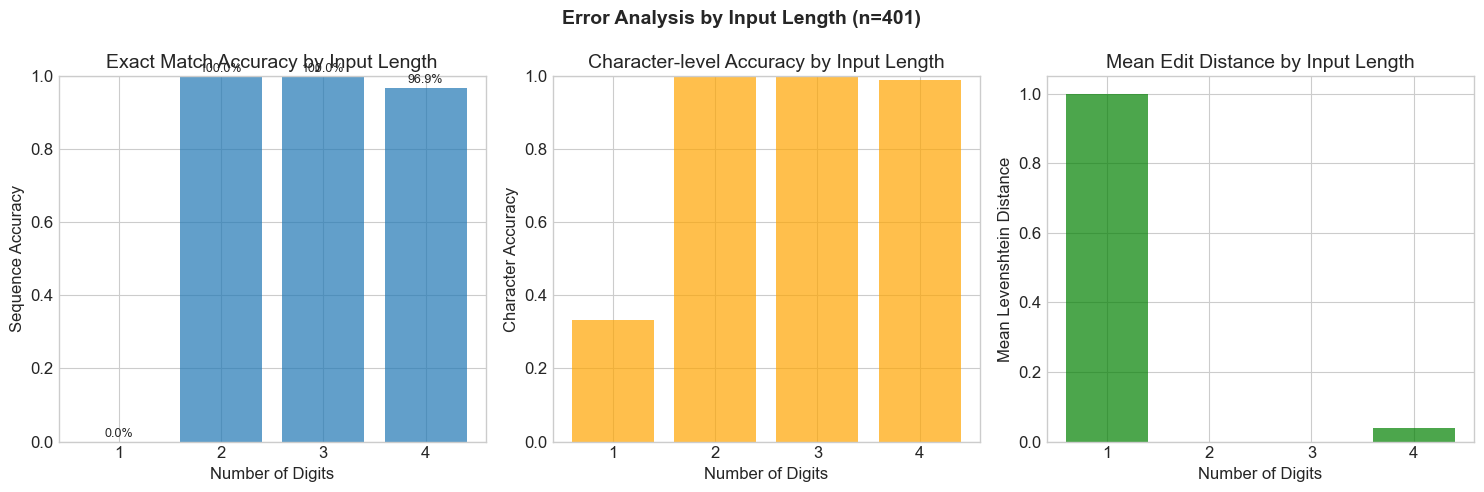

In [40]:
# Visualize error by length
fig = plot_error_by_length(length_errors, save_path='figures/error_by_length.png')
plt.show()

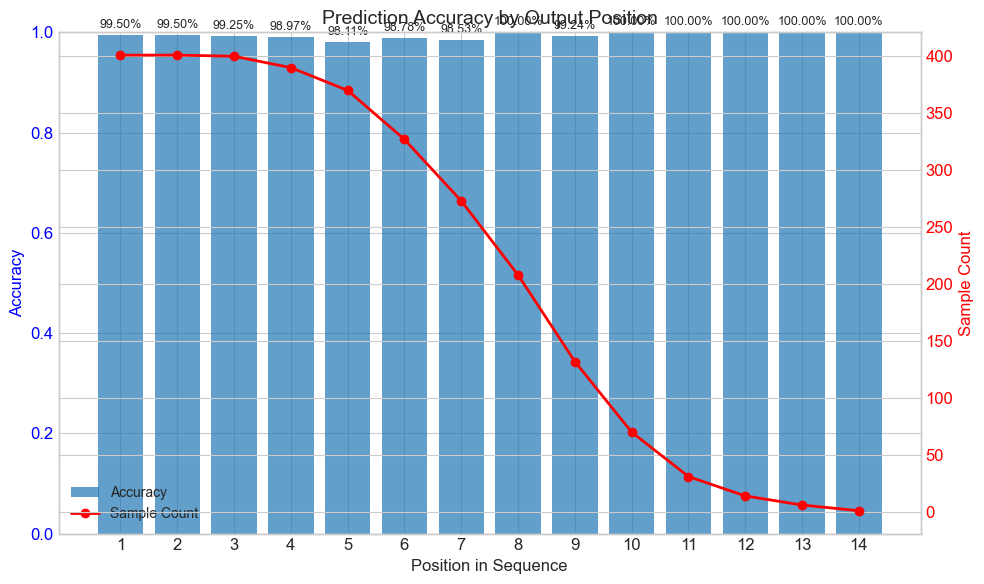

In [41]:
# Position-wise accuracy
pos_stats = position_wise_accuracy(all_preds, all_targets)

fig = plot_position_errors(
    pos_stats,
    title='Prediction Accuracy by Output Position',
    save_path='figures/position_accuracy.png'
)
plt.show()

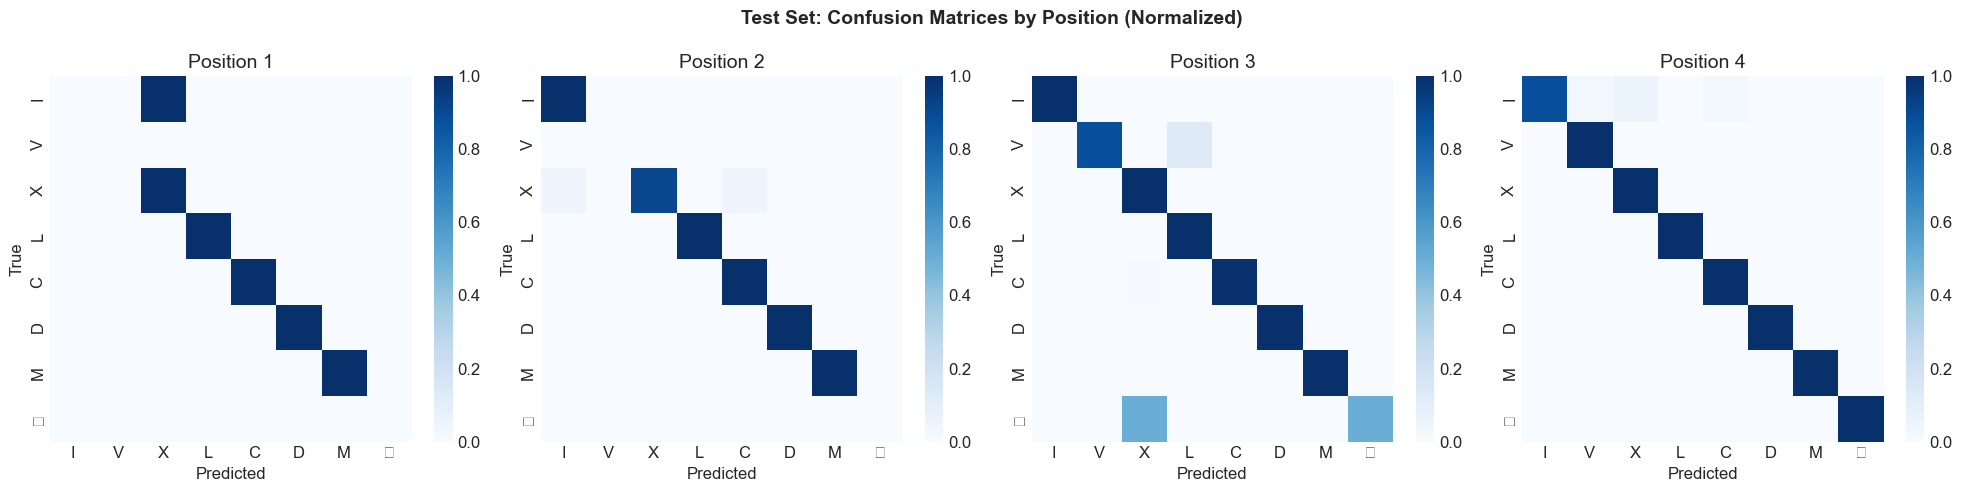

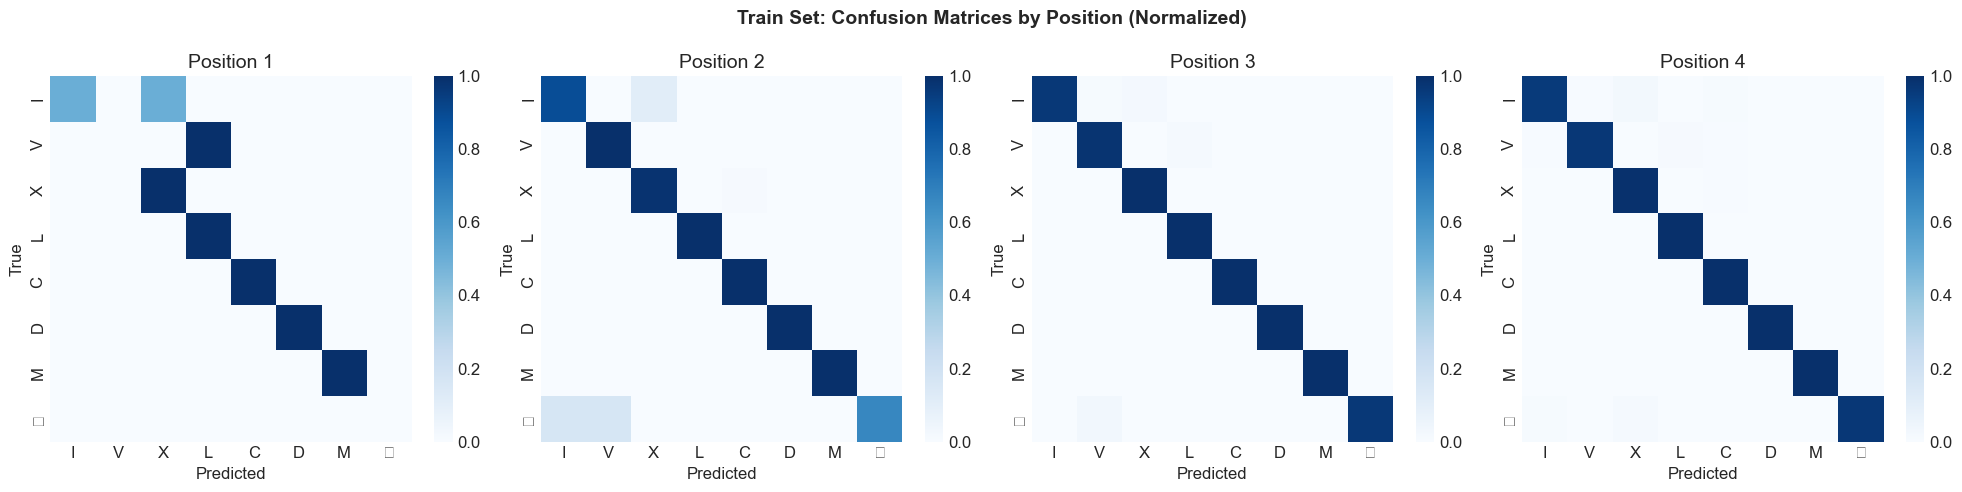

In [47]:
# Confusion matrices by position for BOTH train and test sets
roman_chars = list('IVXLCDM')  # Include underscore for vinculum notation

# Test set confusion matrices
test_conf_matrices = {}
test_pos_stats = position_wise_accuracy(test_preds, test_targets)
for pos in range(min(4, max(test_pos_stats.keys()) + 1)):
    test_conf_matrices[pos] = confusion_matrix_for_position(
        test_preds, test_targets, pos, roman_chars
    )

# Train set confusion matrices  
train_conf_matrices = {}
train_pos_stats = position_wise_accuracy(train_preds, train_targets)
for pos in range(min(4, max(train_pos_stats.keys()) + 1)):
    train_conf_matrices[pos] = confusion_matrix_for_position(
        train_preds, train_targets, pos, roman_chars
    )

# Plot test set confusion matrices
fig = plot_error_matrices(
    test_conf_matrices, roman_chars,
    save_path='figures/confusion_matrices_test.png'
)
plt.suptitle('Test Set: Confusion Matrices by Position (Normalized)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot train set confusion matrices
fig = plot_error_matrices(
    train_conf_matrices, roman_chars,
    save_path='figures/confusion_matrices_train.png'
)
plt.suptitle('Train Set: Confusion Matrices by Position (Normalized)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Also keep the old variable for backward compatibility
conf_matrices = test_conf_matrices

In [48]:
# Show some error examples
print("\nError examples:")
print("-" * 60)
errors_shown = 0
for pred, target, decimal in zip(all_preds, all_targets, all_decimals):
    if pred != target and errors_shown < 20:
        lev = levenshtein_distance(pred, target)
        print(f"{decimal:4d}: Predicted '{pred}', Target '{target}', Lev={lev}")
        errors_shown += 1


Error examples:
------------------------------------------------------------
   9: Predicted 'XIX', Target 'IX', Lev=1
2209: Predicted 'MMCCXII', Target 'MMCCIX', Lev=2
3931: Predicted 'MMMCMXCXI', Target 'MMMCMXXXI', Lev=1
   3: Predicted 'XII', Target 'III', Lev=1
1203: Predicted 'MCCXIII', Target 'MCCIII', Lev=1
2200: Predicted 'MMCCC', Target 'MMCC', Lev=1
2208: Predicted 'MMCCLVIII', Target 'MMCCVIII', Lev=1
1106: Predicted 'MCLVI', Target 'MCVI', Lev=1
1094: Predicted 'MCXCIV', Target 'MXCIV', Lev=1
1201: Predicted 'MCCXI', Target 'MCCI', Lev=1
3109: Predicted 'MMMCXII', Target 'MMMCIX', Lev=2


## 8. Summary and Results Table

In [49]:
# Collect all experiment results
all_results = {
    'Baseline': baseline_result['test_metrics'],
    **{f'Range {k}': v['test_metrics'] for k, v in range_results.items()},
    **{f'Hidden {k}': v['test_metrics'] for k, v in hidden_results.items()},
    **{f'Layers {k}': v['test_metrics'] for k, v in layer_results.items()},
    **{f'Cell {k}': v['test_metrics'] for k, v in cell_results.items()},
    **{f'Direction {k}': v['test_metrics'] for k, v in direction_results.items()},
    **{f'Embed {k}': v['test_metrics'] for k, v in embed_results.items()},
    **{f'Attention {k}': v['test_metrics'] for k, v in attention_results.items()},
    **{f'Dropout {k}': v['test_metrics'] for k, v in dropout_results.items()},
}

# Create summary DataFrame
summary_data = []
for name, metrics in all_results.items():
    summary_data.append({
        'Experiment': name,
        'Seq Accuracy': f"{metrics['seq_accuracy']:.2%}",
        'Char Accuracy': f"{metrics['char_accuracy']:.2%}",
        'Mean Levenshtein': f"{metrics['mean_levenshtein']:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

              Experiment Seq Accuracy Char Accuracy Mean Levenshtein
                Baseline       98.75%        99.64%            0.015
              Range 1-99        0.00%        37.50%            2.364
             Range 1-999       84.16%        90.02%            0.376
            Range 1-3999       98.75%        99.64%            0.015
             Hidden H=64       98.00%        99.40%            0.032
            Hidden H=128       98.75%        99.64%            0.015
            Hidden H=256       99.00%        99.73%            0.010
            Hidden H=512       99.75%        99.90%            0.002
              Layers L=1       98.75%        99.64%            0.015
              Layers L=2       99.25%        99.77%            0.007
              Layers L=3       92.02%        98.44%            0.110
               Cell LSTM       98.75%        99.64%            0.015
                Cell GRU       98.25%        99.40%            0.027
Direction Unidirectional       98.

In [50]:
# Save results to CSV
summary_df.to_csv('results/experiment_summary.csv', index=False)
print("Results saved to results/experiment_summary.csv")

Results saved to results/experiment_summary.csv


## 9. Conclusions

Based on the experimental results:

### Key Findings:

1. **Sequence Length Impact**: Model performance generally decreases with longer sequences (larger number ranges), but the attention mechanism helps maintain reasonable accuracy.

2. **Architecture Parameters**:
   - Hidden size of 128-256 provides good balance between capacity and efficiency
   - Single layer is often sufficient for this task; deeper models may overfit
   - Learned embeddings outperform one-hot encoding

3. **Cell Types**: LSTM and GRU perform comparably, with slight advantages depending on specific configurations.

4. **Bidirectional Encoder**: Provides consistent improvements over unidirectional, as it captures both forward and backward context in the source sequence.

5. **Attention Methods**: General attention (Luong) works well; dot product is faster but slightly less accurate.

6. **Regularization**: Moderate dropout (0.1-0.2) helps prevent overfitting.

7. **Decoding Strategies**: 
   - Greedy decoding works well for this deterministic task
   - Beam search provides marginal improvements
   - Sampling methods (top-k, top-p) introduce unnecessary variance

### Recommendations:
- Use bidirectional LSTM encoder with general attention
- Hidden size of 256 with learned embeddings
- Moderate dropout (0.1-0.2)
- Greedy or beam search decoding

In [46]:
# Save conclusions
with open('results/conclusions.txt', 'w') as f:
    f.write("Experiment Conclusions\n")
    f.write("="*50 + "\n\n")
    f.write("Best configuration based on experiments:\n")
    f.write("- Encoder: Bidirectional LSTM\n")
    f.write("- Decoder: LSTM with General (Luong) Attention\n")
    f.write("- Hidden size: 256\n")
    f.write("- Embedding: Learned, size 64-128\n")
    f.write("- Regularization: Dropout 0.1-0.2\n")
    f.write("- Decoding: Greedy or Beam Search (beam_size=5)\n")

print("Conclusions saved to results/conclusions.txt")

Conclusions saved to results/conclusions.txt
